开始数据预处理...
原始数据列名: ['编号', '性别', '籍贯', '身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量', '喜欢颜色', '喜欢运动', '喜欢文学']
数据形状: (1075, 11)
性别列唯一值: [1.  0.  0.5 nan]
过滤后数据量: 1072
身高(cm) - 非空值数量: 1071
体重(kg) - 非空值数量: 1070
50米成绩 - 非空值数量: 1060
肺活量 - 非空值数量: 1063
鞋码 - 非空值数量: 1069
删除缺失值后数据量: 1058
特征 身高(cm): 移除 1 个异常值
特征 体重(kg): 移除 1 个异常值
最终处理后数据量: 1056
男生数量: 845
女生数量: 211

分析不同K值的影响...
男生数据量: 845
女生数据量: 211
正在计算 K=2...
正在计算 K=3...
正在计算 K=4...
正在计算 K=5...
正在计算 K=6...
正在计算 K=7...
正在计算 K=8...

绘制肘部法则和轮廓系数图...


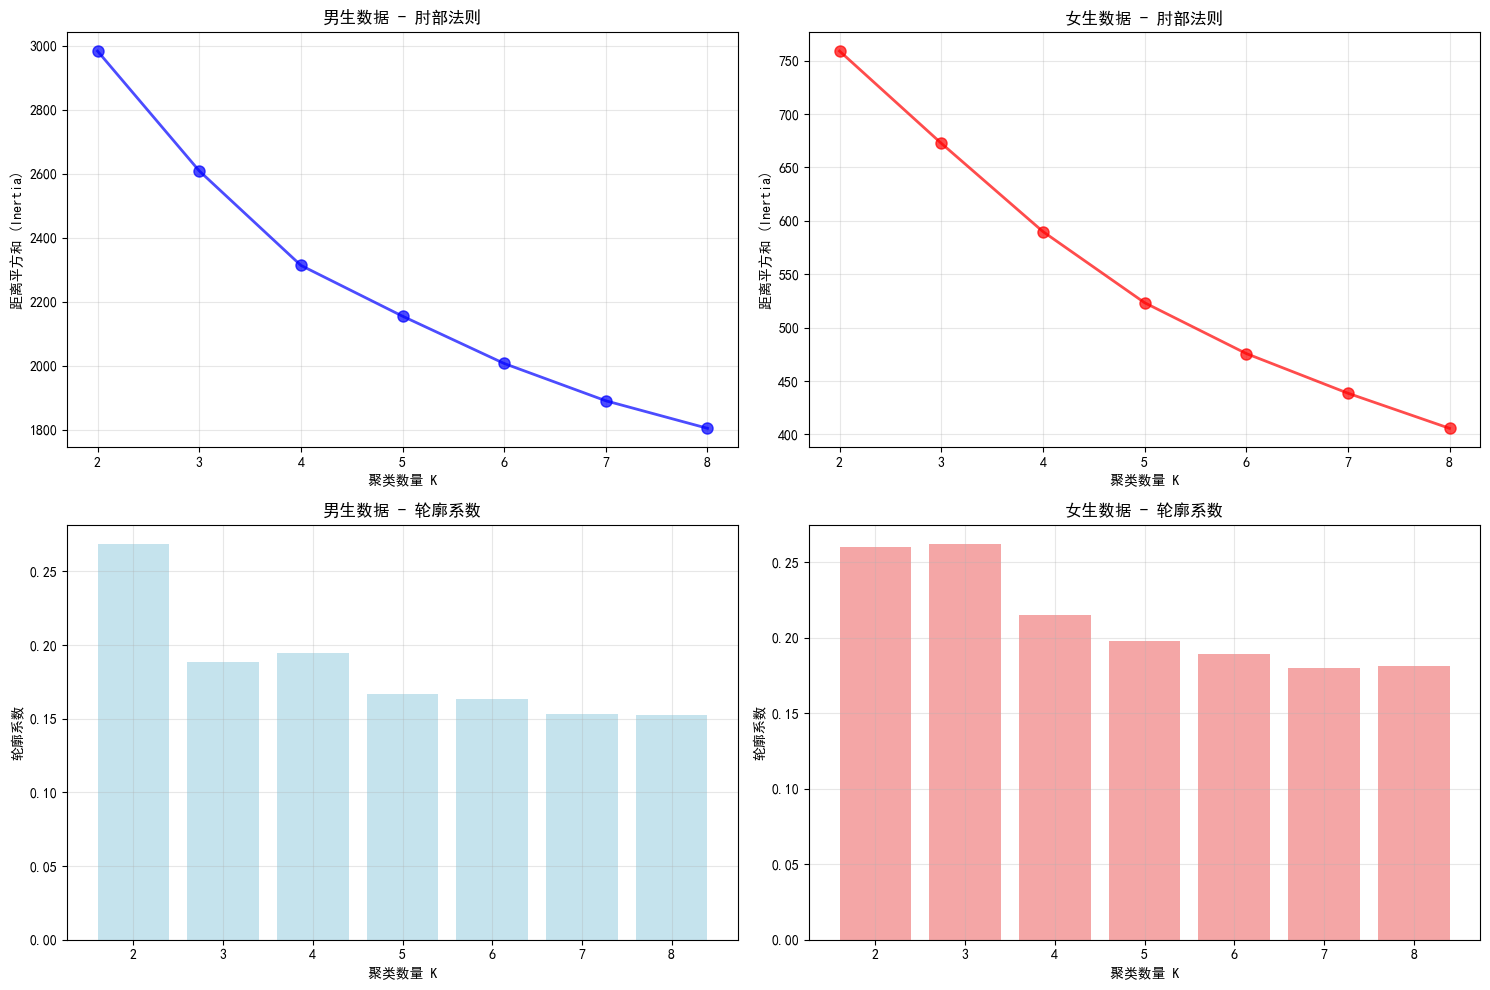


男生最优K值: 2
女生最优K值: 3

绘制聚类结果...


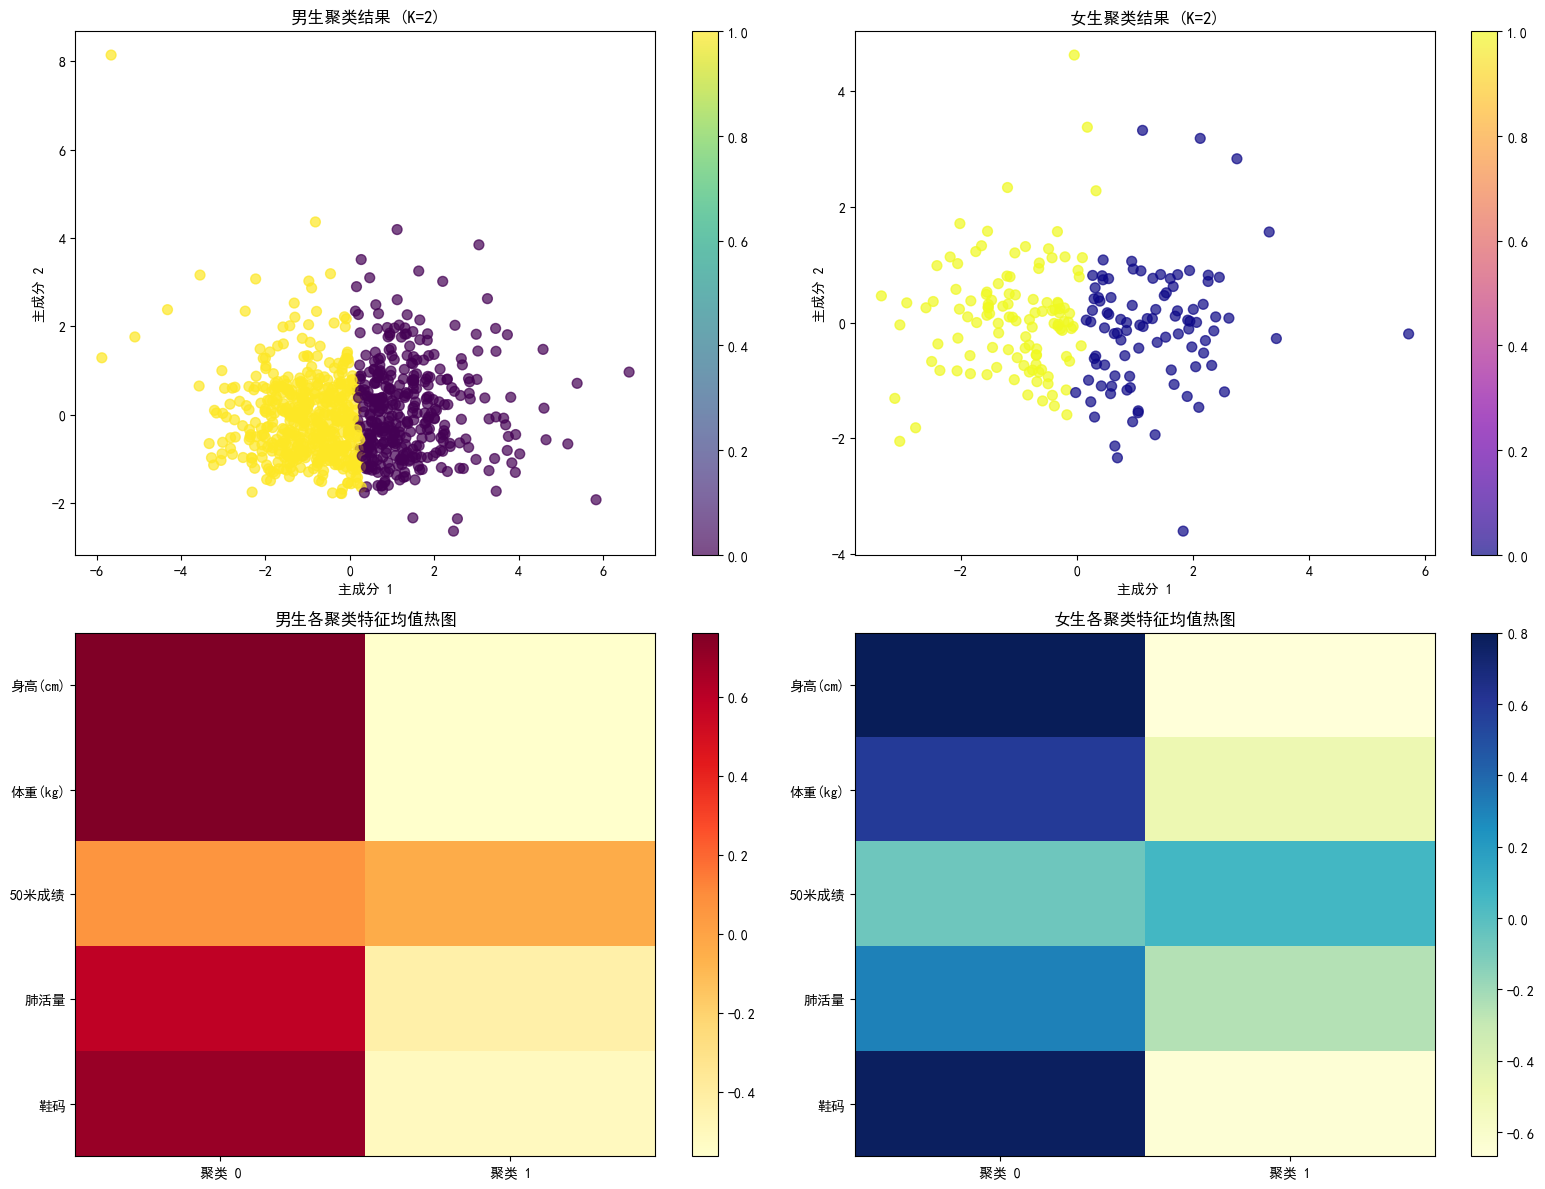


分析不同初始值的影响...

绘制初始值比较图...


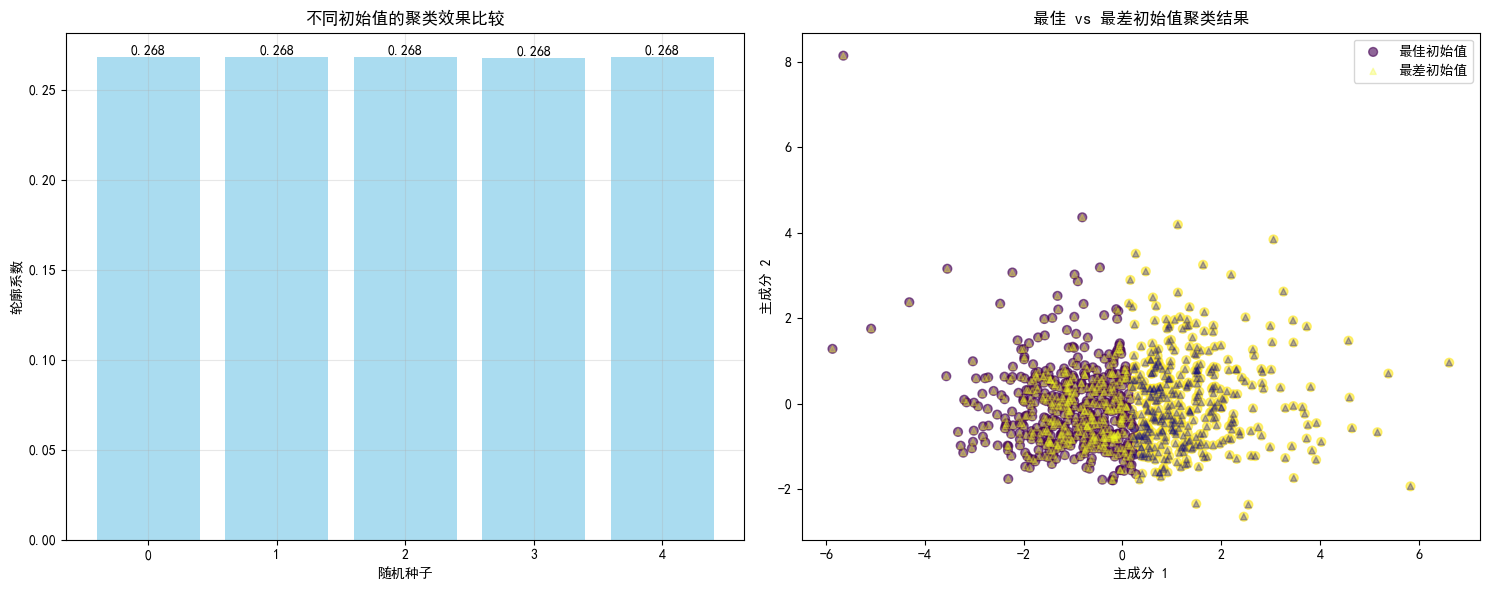

最佳初始值 (种子=0): 轮廓系数 = 0.2683
最差初始值 (种子=3): 轮廓系数 = 0.2677

聚类分析统计摘要
K=2: 男生轮廓系数=0.2683
K=3: 男生轮廓系数=0.1883
K=4: 男生轮廓系数=0.1948
K=5: 男生轮廓系数=0.1667
K=6: 男生轮廓系数=0.1635
K=7: 男生轮廓系数=0.1531
K=8: 男生轮廓系数=0.1522
K=2: 女生轮廓系数=0.2603
K=3: 女生轮廓系数=0.2617
K=4: 女生轮廓系数=0.2151
K=5: 女生轮廓系数=0.1976
K=6: 女生轮廓系数=0.1895
K=7: 女生轮廓系数=0.1800
K=8: 女生轮廓系数=0.1810

数据统计:
男生样本数: 845
女生样本数: 211

男生特征均值:
身高(cm)     174.712544
体重(kg)      68.220237
50米成绩        7.557598
肺活量       4260.297041
鞋码          42.003550
dtype: float64

女生特征均值:
身高(cm)     163.483412
体重(kg)      52.445498
50米成绩        8.895498
肺活量       3191.052133
鞋码          37.414692
dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class StudentClustering:
    def __init__(self, data_path):
        """初始化聚类分析类"""
        self.data = pd.read_excel(data_path)
        # 修正列名
        self.data = self.data.rename(columns={'性别 男1女0': '性别'})
        self.features = ['身高(cm)', '体重(kg)', '50米成绩', '肺活量', '鞋码']
        self.processed_data = None
        
    def preprocess_data(self):
        """数据预处理"""
        # 复制数据
        df = self.data.copy()
        
        print("原始数据列名:", df.columns.tolist())
        print("数据形状:", df.shape)
        
        # 处理异常值和不规范数据
        df['性别'] = pd.to_numeric(df['性别'], errors='coerce')
        print(f"性别列唯一值: {df['性别'].unique()}")
        
        # 只保留性别为0或1的记录
        df = df[df['性别'].isin([0, 1])]
        print(f"过滤后数据量: {len(df)}")
        
        # 处理特征数据
        for feature in self.features:
            df[feature] = pd.to_numeric(df[feature], errors='coerce')
            print(f"{feature} - 非空值数量: {df[feature].notna().sum()}")
        
        # 删除缺失值
        df_clean = df.dropna(subset=self.features)
        print(f"删除缺失值后数据量: {len(df_clean)}")
        
        # 去除极端异常值
        initial_count = len(df_clean)
        for feature in self.features:
            Q1 = df_clean[feature].quantile(0.05)  # 使用5%和95%分位数，更宽松
            Q3 = df_clean[feature].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 使用3倍IQR，更宽松
            upper_bound = Q3 + 3 * IQR
            
            before = len(df_clean)
            df_clean = df_clean[(df_clean[feature] >= lower_bound) & 
                              (df_clean[feature] <= upper_bound)]
            after = len(df_clean)
            if before != after:
                print(f"特征 {feature}: 移除 {before - after} 个异常值")
        
        print(f"最终处理后数据量: {len(df_clean)}")
        print(f"男生数量: {len(df_clean[df_clean['性别'] == 1])}")
        print(f"女生数量: {len(df_clean[df_clean['性别'] == 0])}")
        
        self.processed_data = df_clean
        return df_clean
    
    def analyze_different_k(self, max_k=8):
        """分析不同K值对聚类效果的影响"""
        df = self.processed_data
        
        # 分离男女生数据
        male_data = df[df['性别'] == 1][self.features]
        female_data = df[df['性别'] == 0][self.features]
        
        print(f"男生数据量: {len(male_data)}")
        print(f"女生数据量: {len(female_data)}")
        
        # 标准化数据
        scaler = StandardScaler()
        male_scaled = scaler.fit_transform(male_data)
        female_scaled = scaler.fit_transform(female_data)
        
        results = {'male': {}, 'female': {}}
        
        for k in range(2, max_k + 1):
            print(f"正在计算 K={k}...")
            
            # 男生聚类
            if len(male_data) >= k:  # 确保样本数大于聚类数
                kmeans_male = KMeans(n_clusters=k, random_state=42, n_init=10)
                male_labels = kmeans_male.fit_predict(male_scaled)
                male_silhouette = silhouette_score(male_scaled, male_labels)
            else:
                male_silhouette = -1
                male_labels = None
            
            # 女生聚类
            if len(female_data) >= k:
                kmeans_female = KMeans(n_clusters=k, random_state=42, n_init=10)
                female_labels = kmeans_female.fit_predict(female_scaled)
                female_silhouette = silhouette_score(female_scaled, female_labels)
            else:
                female_silhouette = -1
                female_labels = None
            
            results['male'][k] = {
                'inertia': kmeans_male.inertia_ if len(male_data) >= k else None,
                'silhouette': male_silhouette,
                'labels': male_labels
            }
            results['female'][k] = {
                'inertia': kmeans_female.inertia_ if len(female_data) >= k else None,
                'silhouette': female_silhouette,
                'labels': female_labels
            }
        
        return results, male_scaled, female_scaled, male_data, female_data
    
    def plot_elbow_silhouette(self, results):
        """绘制肘部法则和轮廓系数图"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # 男生肘部法则
        k_values = [k for k in results['male'].keys() if results['male'][k]['inertia'] is not None]
        male_inertia = [results['male'][k]['inertia'] for k in k_values]
        ax1.plot(k_values, male_inertia, 'bo-', alpha=0.7, linewidth=2, markersize=8)
        ax1.set_xlabel('聚类数量 K')
        ax1.set_ylabel('距离平方和 (Inertia)')
        ax1.set_title('男生数据 - 肘部法则')
        ax1.grid(True, alpha=0.3)
        
        # 女生肘部法则
        k_values_f = [k for k in results['female'].keys() if results['female'][k]['inertia'] is not None]
        female_inertia = [results['female'][k]['inertia'] for k in k_values_f]
        ax2.plot(k_values_f, female_inertia, 'ro-', alpha=0.7, linewidth=2, markersize=8)
        ax2.set_xlabel('聚类数量 K')
        ax2.set_ylabel('距离平方和 (Inertia)')
        ax2.set_title('女生数据 - 肘部法则')
        ax2.grid(True, alpha=0.3)
        
        # 男生轮廓系数
        k_values_s = [k for k in results['male'].keys() if results['male'][k]['silhouette'] != -1]
        male_silhouette = [results['male'][k]['silhouette'] for k in k_values_s]
        ax3.bar(k_values_s, male_silhouette, color='lightblue', alpha=0.7)
        ax3.set_xlabel('聚类数量 K')
        ax3.set_ylabel('轮廓系数')
        ax3.set_title('男生数据 - 轮廓系数')
        ax3.grid(True, alpha=0.3)
        
        # 女生轮廓系数
        k_values_sf = [k for k in results['female'].keys() if results['female'][k]['silhouette'] != -1]
        female_silhouette = [results['female'][k]['silhouette'] for k in k_values_sf]
        ax4.bar(k_values_sf, female_silhouette, color='lightcoral', alpha=0.7)
        ax4.set_xlabel('聚类数量 K')
        ax4.set_ylabel('轮廓系数')
        ax4.set_title('女生数据 - 轮廓系数')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_cluster_results(self, results, male_scaled, female_scaled, k=4):
        """绘制聚类结果"""
        # 使用PCA降维进行可视化
        pca = PCA(n_components=2)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 男生聚类结果
        if results['male'][k]['labels'] is not None:
            male_pca = pca.fit_transform(male_scaled)
            male_labels = results['male'][k]['labels']
            
            scatter1 = ax1.scatter(male_pca[:, 0], male_pca[:, 1], c=male_labels, 
                                  cmap='viridis', alpha=0.7, s=50)
            ax1.set_xlabel('主成分 1')
            ax1.set_ylabel('主成分 2')
            ax1.set_title(f'男生聚类结果 (K={k})')
            plt.colorbar(scatter1, ax=ax1)
        else:
            ax1.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title(f'男生聚类结果 (K={k})')
        
        # 女生聚类结果
        if results['female'][k]['labels'] is not None:
            female_pca = pca.fit_transform(female_scaled)
            female_labels = results['female'][k]['labels']
            
            scatter2 = ax2.scatter(female_pca[:, 0], female_pca[:, 1], c=female_labels, 
                                  cmap='plasma', alpha=0.7, s=50)
            ax2.set_xlabel('主成分 1')
            ax2.set_ylabel('主成分 2')
            ax2.set_title(f'女生聚类结果 (K={k})')
            plt.colorbar(scatter2, ax=ax2)
        else:
            ax2.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title(f'女生聚类结果 (K={k})')
        
        # 男生特征分布
        if results['male'][k]['labels'] is not None:
            male_data_for_plot = pd.DataFrame(male_scaled, columns=self.features)
            male_data_for_plot['cluster'] = male_labels
            
            cluster_means_male = male_data_for_plot.groupby('cluster').mean()
            im1 = ax3.imshow(cluster_means_male.T, cmap='YlOrRd', aspect='auto')
            ax3.set_xticks(range(len(cluster_means_male)))
            ax3.set_xticklabels([f'聚类 {i}' for i in range(len(cluster_means_male))])
            ax3.set_yticks(range(len(self.features)))
            ax3.set_yticklabels(self.features)
            ax3.set_title('男生各聚类特征均值热图')
            plt.colorbar(im1, ax=ax3)
        else:
            ax3.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('男生各聚类特征均值热图')
        
        # 女生特征分布
        if results['female'][k]['labels'] is not None:
            female_data_for_plot = pd.DataFrame(female_scaled, columns=self.features)
            female_data_for_plot['cluster'] = female_labels
            
            cluster_means_female = female_data_for_plot.groupby('cluster').mean()
            im2 = ax4.imshow(cluster_means_female.T, cmap='YlGnBu', aspect='auto')
            ax4.set_xticks(range(len(cluster_means_female)))
            ax4.set_xticklabels([f'聚类 {i}' for i in range(len(cluster_means_female))])
            ax4.set_yticks(range(len(self.features)))
            ax4.set_yticklabels(self.features)
            ax4.set_title('女生各聚类特征均值热图')
            plt.colorbar(im2, ax=ax4)
        else:
            ax4.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('女生各聚类特征均值热图')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_different_init(self, k=4, n_inits=5):
        """分析不同初始值对聚类结果的影响"""
        df = self.processed_data
        
        male_data = df[df['性别'] == 1][self.features]
        
        if len(male_data) < k:
            print(f"男生数据量({len(male_data)})不足以进行K={k}的聚类分析")
            return [], None
        
        scaler = StandardScaler()
        male_scaled = scaler.fit_transform(male_data)
        
        init_results = []
        
        for init in range(n_inits):
            kmeans = KMeans(n_clusters=k, random_state=init, n_init=1)
            labels = kmeans.fit_predict(male_scaled)
            silhouette = silhouette_score(male_scaled, labels)
            
            init_results.append({
                'init_seed': init,
                'inertia': kmeans.inertia_,
                'silhouette': silhouette,
                'labels': labels,
                'centers': kmeans.cluster_centers_
            })
        
        return init_results, male_scaled
    
    def plot_init_comparison(self, init_results, male_scaled):
        """绘制不同初始值的比较"""
        if not init_results:
            print("没有可用的初始值比较结果")
            return
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 不同初始值的轮廓系数
        init_seeds = [r['init_seed'] for r in init_results]
        silhouettes = [r['silhouette'] for r in init_results]
        
        bars = ax1.bar(init_seeds, silhouettes, color='skyblue', alpha=0.7)
        ax1.set_xlabel('随机种子')
        ax1.set_ylabel('轮廓系数')
        ax1.set_title('不同初始值的聚类效果比较')
        ax1.grid(True, alpha=0.3)
        
        # 在柱状图上显示数值
        for bar, silhouette in zip(bars, silhouettes):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{silhouette:.3f}', ha='center', va='bottom')
        
        # 使用PCA可视化最佳和最差初始值的结果
        pca = PCA(n_components=2)
        male_pca = pca.fit_transform(male_scaled)
        
        best_idx = np.argmax(silhouettes)
        worst_idx = np.argmin(silhouettes)
        
        best_labels = init_results[best_idx]['labels']
        worst_labels = init_results[worst_idx]['labels']
        
        scatter1 = ax2.scatter(male_pca[:, 0], male_pca[:, 1], c=best_labels, 
                              cmap='viridis', alpha=0.6, s=40, label='最佳初始值')
        ax2.set_xlabel('主成分 1')
        ax2.set_ylabel('主成分 2')
        ax2.set_title('最佳 vs 最差初始值聚类结果')
        
        scatter2 = ax2.scatter(male_pca[:, 0], male_pca[:, 1], c=worst_labels, 
                              cmap='plasma', alpha=0.3, s=20, marker='^', label='最差初始值')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"最佳初始值 (种子={best_idx}): 轮廓系数 = {silhouettes[best_idx]:.4f}")
        print(f"最差初始值 (种子={worst_idx}): 轮廓系数 = {silhouettes[worst_idx]:.4f}")
    
    def run_complete_analysis(self):
        """运行完整的聚类分析"""
        print("开始数据预处理...")
        self.preprocess_data()
        
        if self.processed_data is None or len(self.processed_data) == 0:
            print("数据预处理失败，无法继续分析")
            return
        
        print("\n分析不同K值的影响...")
        results, male_scaled, female_scaled, male_data, female_data = self.analyze_different_k()
        
        print("\n绘制肘部法则和轮廓系数图...")
        self.plot_elbow_silhouette(results)
        
        # 选择最优K值（基于轮廓系数）
        valid_k_male = [k for k in results['male'].keys() if results['male'][k]['silhouette'] != -1]
        valid_k_female = [k for k in results['female'].keys() if results['female'][k]['silhouette'] != -1]
        
        if valid_k_male:
            best_k_male = max(valid_k_male, key=lambda k: results['male'][k]['silhouette'])
            print(f"\n男生最优K值: {best_k_male}")
        else:
            best_k_male = 3
            print("\n男生数据不足，使用默认K=3")
            
        if valid_k_female:
            best_k_female = max(valid_k_female, key=lambda k: results['female'][k]['silhouette'])
            print(f"女生最优K值: {best_k_female}")
        else:
            best_k_female = 3
            print("女生数据不足，使用默认K=3")
        
        print("\n绘制聚类结果...")
        # 使用较小的K值，因为女生数据可能较少
        k_to_use = min(best_k_male, best_k_female, 4)
        self.plot_cluster_results(results, male_scaled, female_scaled, k=k_to_use)
        
        print("\n分析不同初始值的影响...")
        init_results, male_scaled_init = self.analyze_different_init(k=k_to_use)
        
        if init_results:
            print("\n绘制初始值比较图...")
            self.plot_init_comparison(init_results, male_scaled_init)
        
        # 打印统计信息
        self.print_statistical_summary(results, male_data, female_data)

    def print_statistical_summary(self, results, male_data, female_data):
        """打印统计摘要"""
        print("\n" + "="*50)
        print("聚类分析统计摘要")
        print("="*50)
        
        for k in results['male'].keys():
            if results['male'][k]['silhouette'] != -1:
                male_silhouette = results['male'][k]['silhouette']
                print(f"K={k}: 男生轮廓系数={male_silhouette:.4f}")
        
        for k in results['female'].keys():
            if results['female'][k]['silhouette'] != -1:
                female_silhouette = results['female'][k]['silhouette']
                print(f"K={k}: 女生轮廓系数={female_silhouette:.4f}")
        
        print(f"\n数据统计:")
        print(f"男生样本数: {len(male_data)}")
        print(f"女生样本数: {len(female_data)}")
        
        if len(male_data) > 0:
            print(f"\n男生特征均值:")
            print(male_data.mean())
        
        if len(female_data) > 0:
            print(f"\n女生特征均值:")
            print(female_data.mean())

# 使用示例
if __name__ == "__main__":
    # 创建聚类分析实例
    analyzer = StudentClustering("2025-模式识别作业数据集汇总-.xlsx")
    
    # 运行完整分析
    analyzer.run_complete_analysis()

开始数据预处理...
原始数据列名: ['编号', '性别', '籍贯', '身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量', '喜欢颜色', '喜欢运动', '喜欢文学']
数据形状: (1075, 11)
性别列唯一值: [1.  0.  0.5 nan]
过滤后数据量: 1072
身高(cm) - 非空值数量: 1071
体重(kg) - 非空值数量: 1070
50米成绩 - 非空值数量: 1060
肺活量 - 非空值数量: 1063
鞋码 - 非空值数量: 1069
删除缺失值后数据量: 1058
特征 身高(cm): 移除 1 个异常值
特征 体重(kg): 移除 1 个异常值
最终处理后数据量: 1056
男生数量: 845
女生数量: 211

男生数据量: 845
女生数据量: 211

男生层次聚类分析


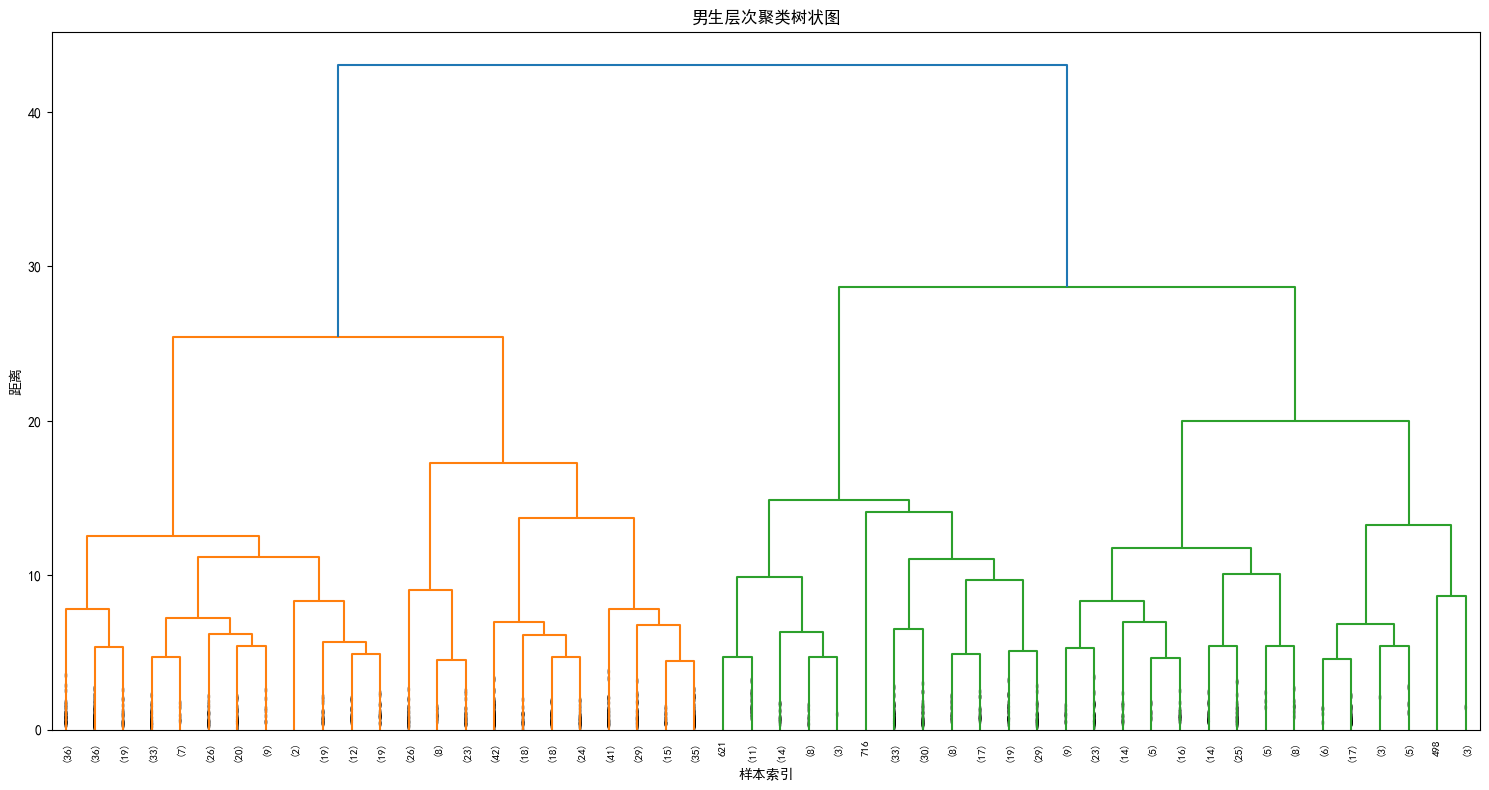


比较不同连接方法...


<Figure size 640x480 with 0 Axes>

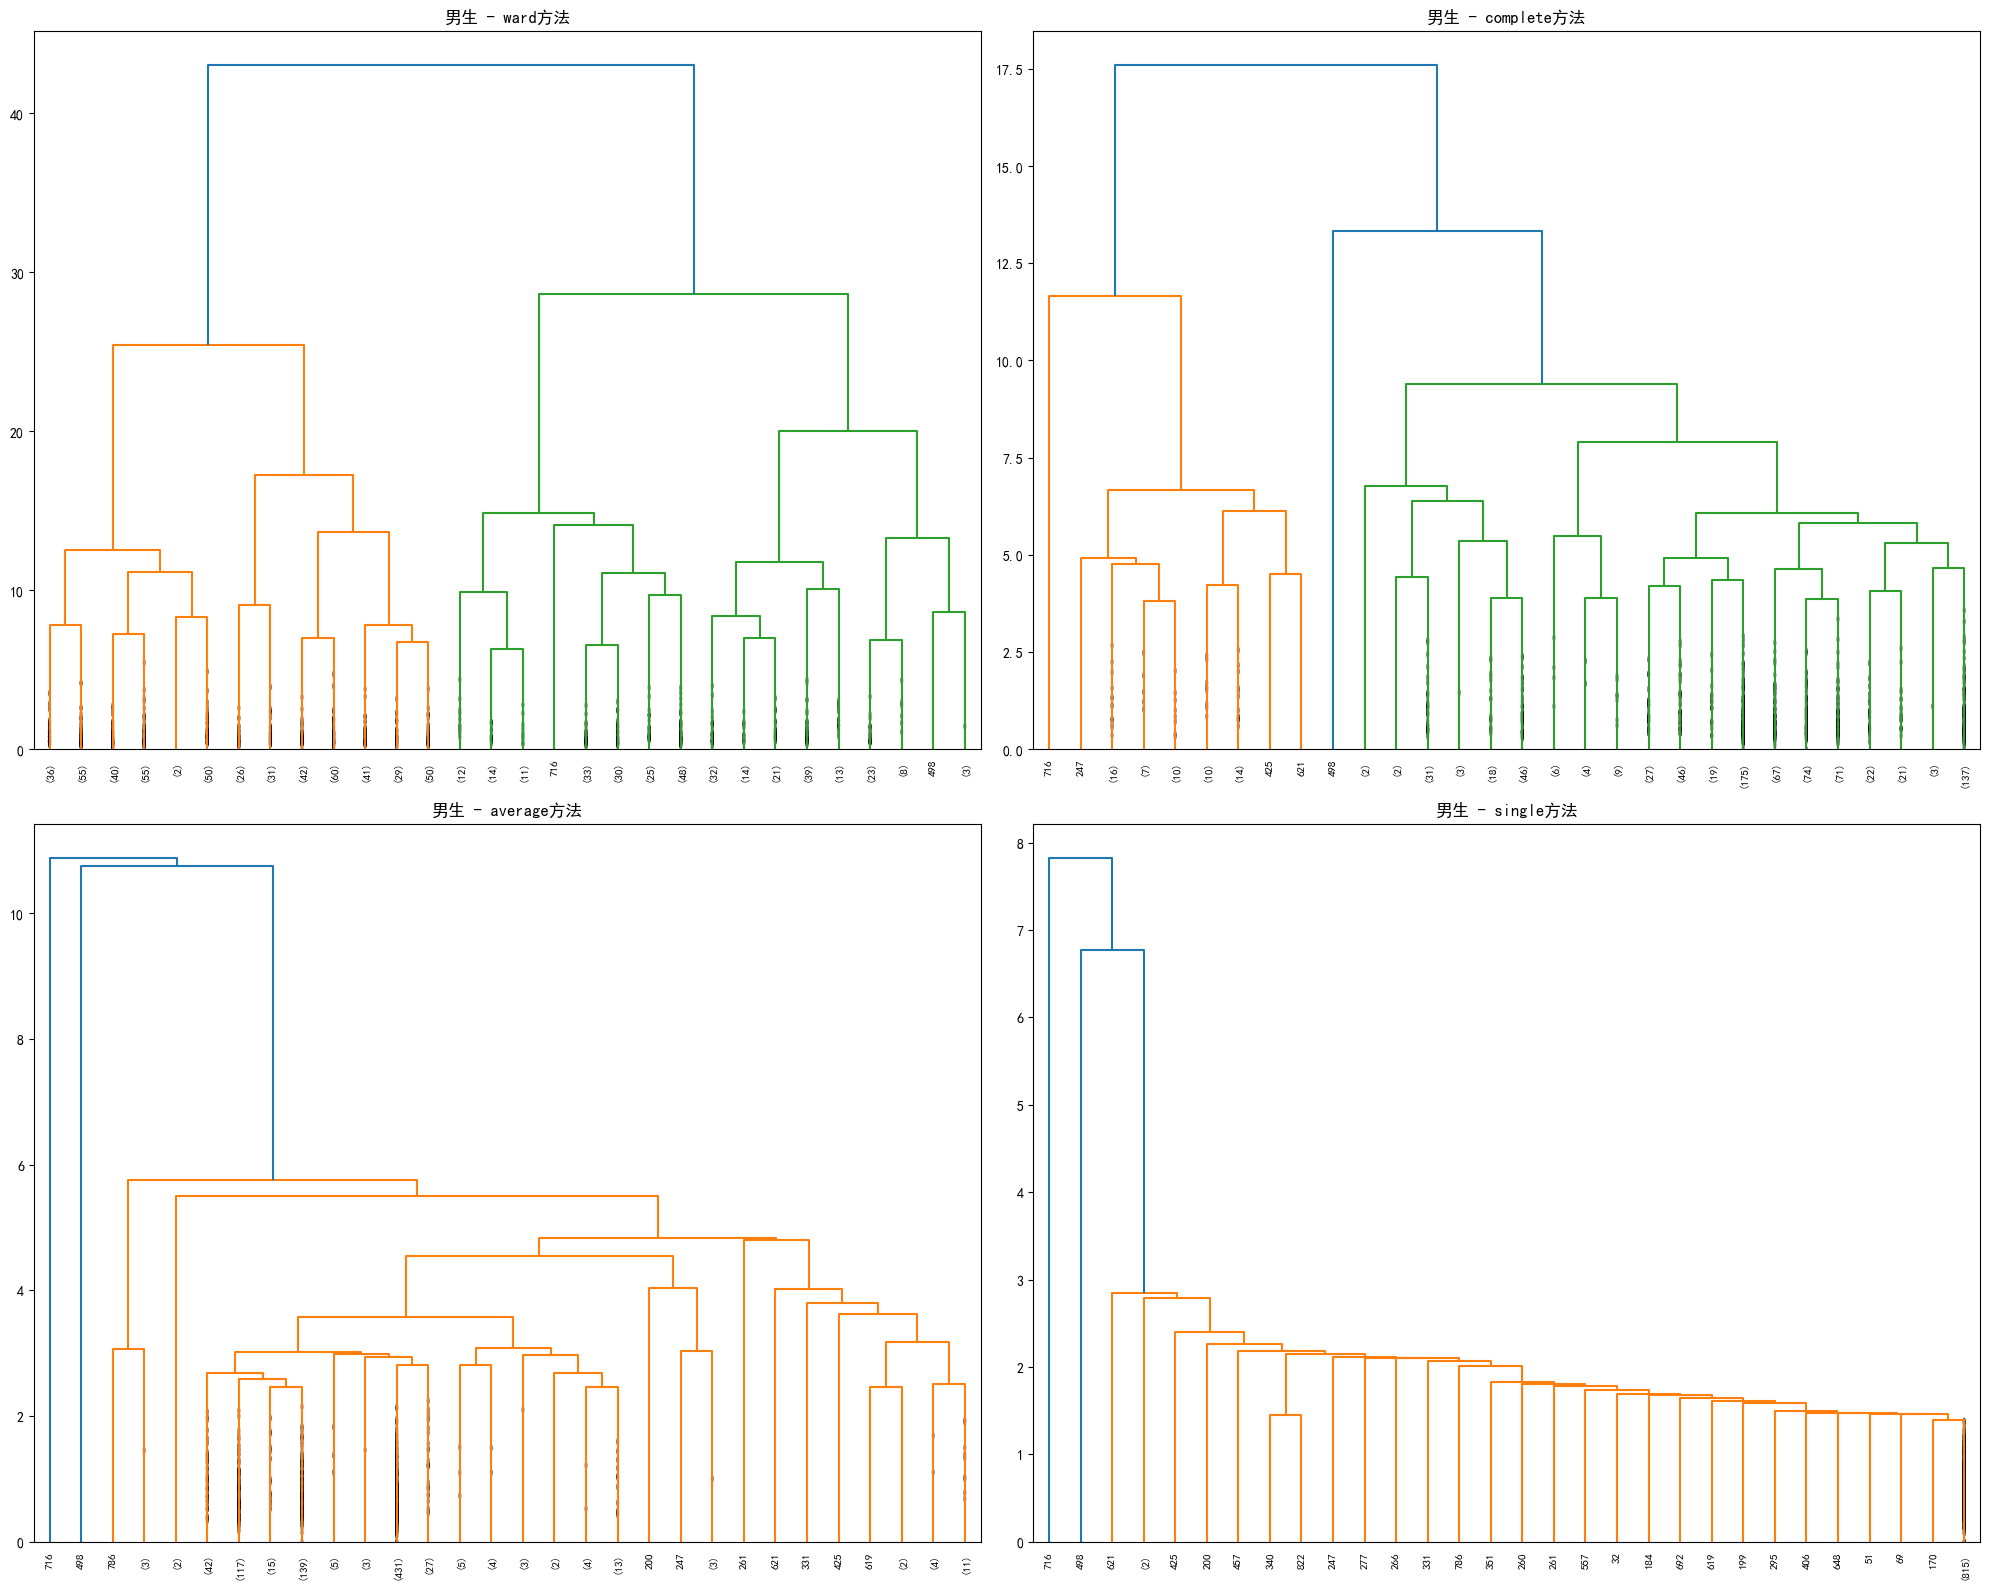


分析不同聚类数量...


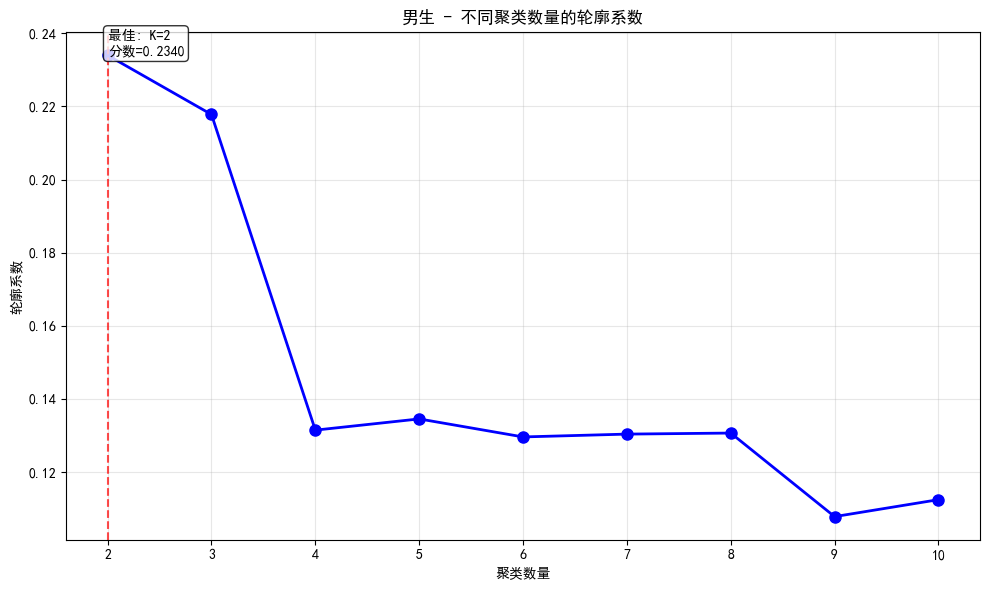


使用最佳聚类数 K=2 进行可视化...


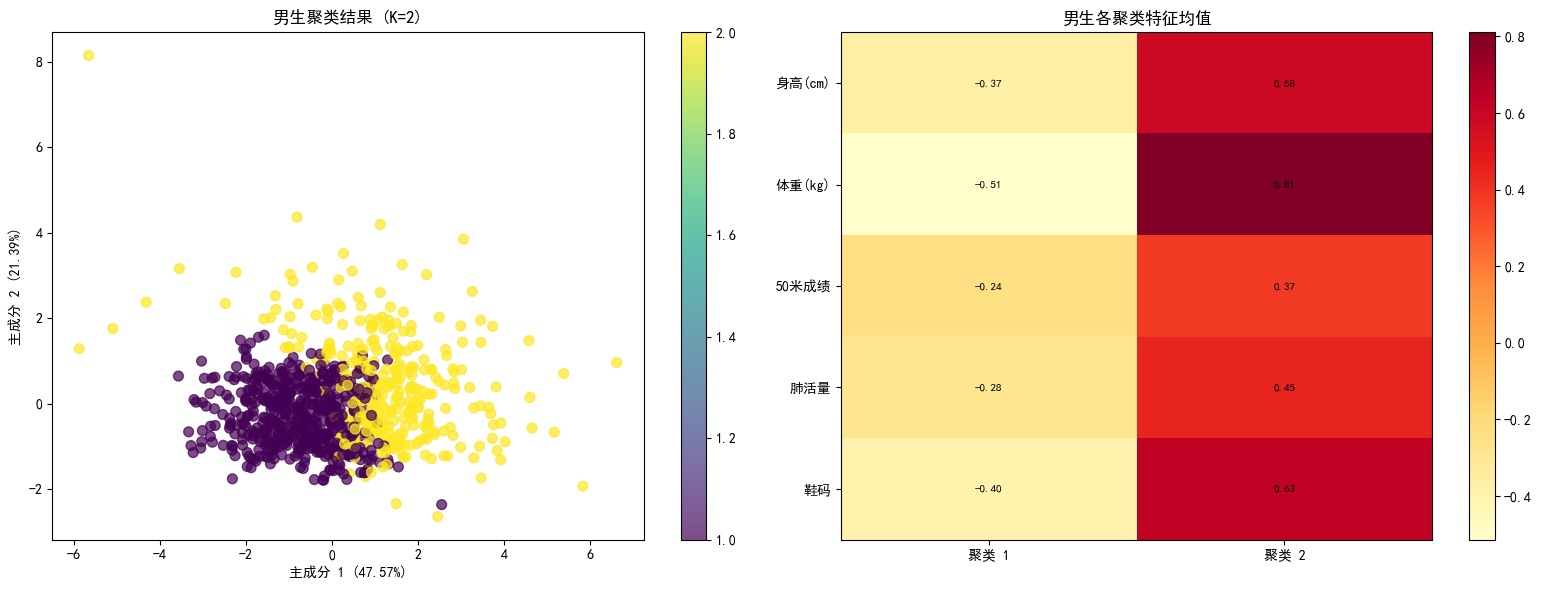


男生各聚类特征分析:

聚类 1 (样本数: 517)
  身高(cm): -0.37 ± 0.78
  体重(kg): -0.51 ± 0.61
  50米成绩: -0.24 ± 0.71
  肺活量: -0.28 ± 0.90
  鞋码: -0.40 ± 0.72

聚类 2 (样本数: 328)
  身高(cm): 0.58 ± 1.03
  体重(kg): 0.81 ± 0.96
  50米成绩: 0.37 ± 1.25
  肺活量: 0.45 ± 0.98
  鞋码: 0.63 ± 1.06


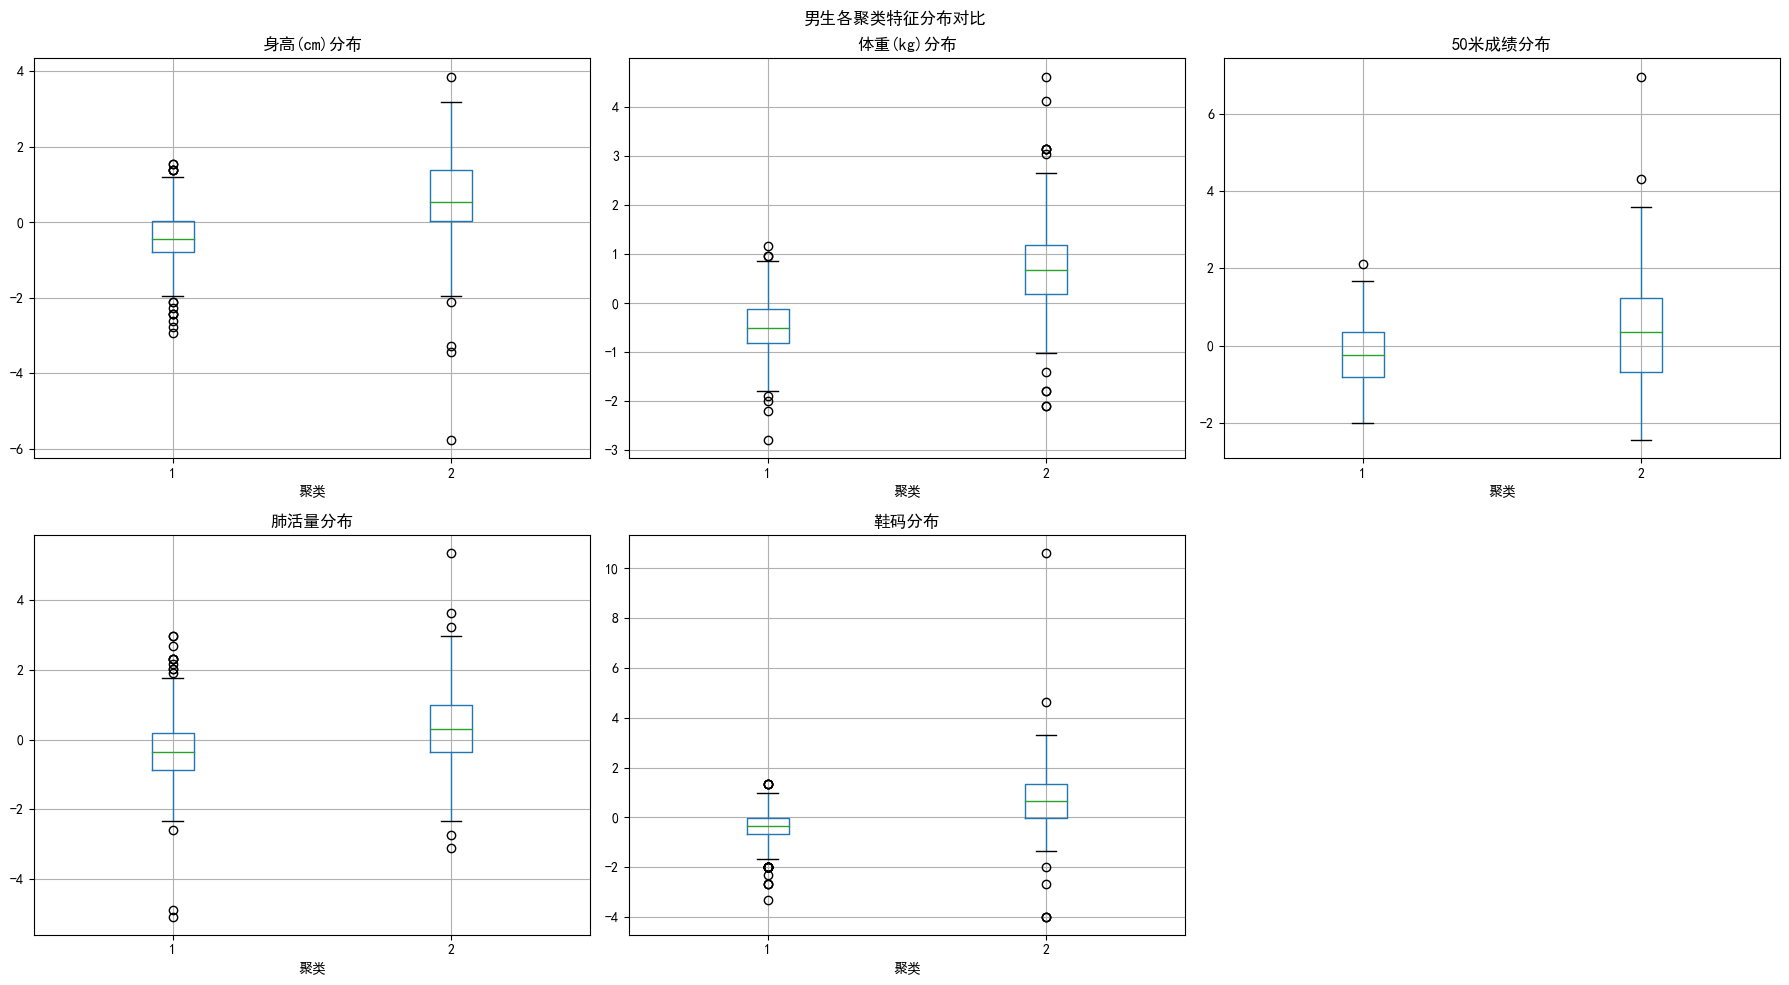


女生层次聚类分析


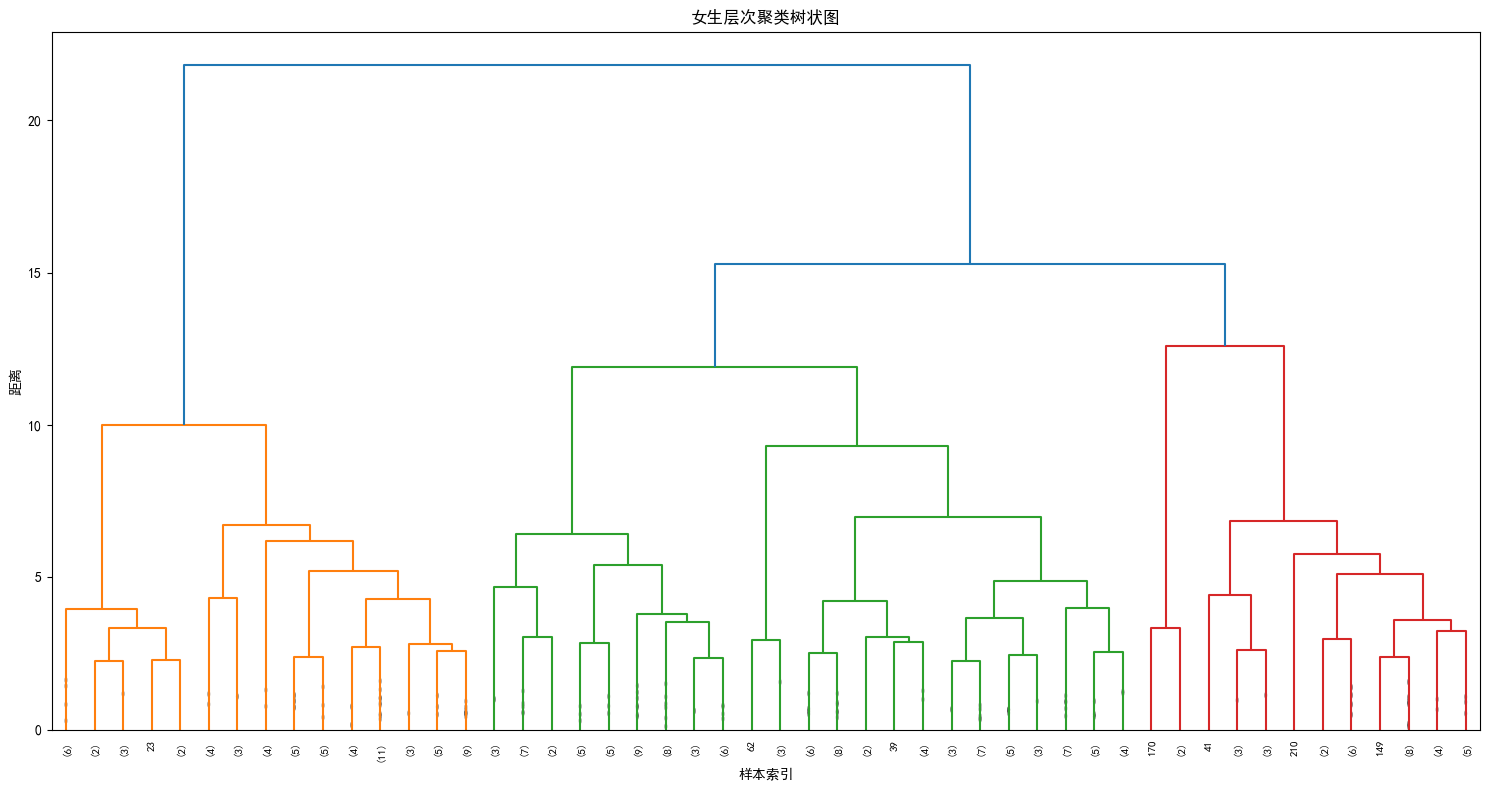


分析不同聚类数量...


<Figure size 640x480 with 0 Axes>

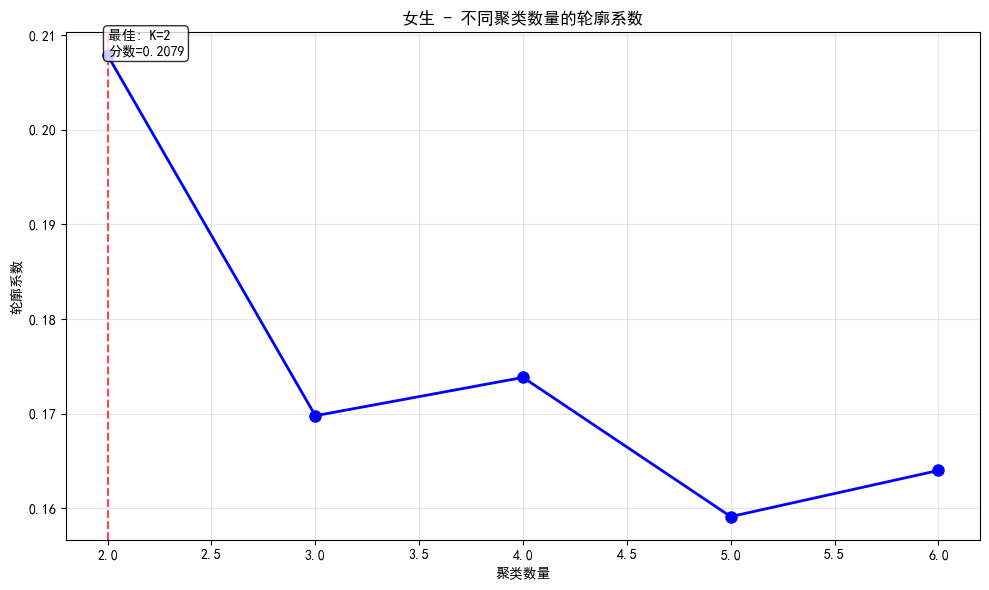


使用最佳聚类数 K=2 进行可视化...


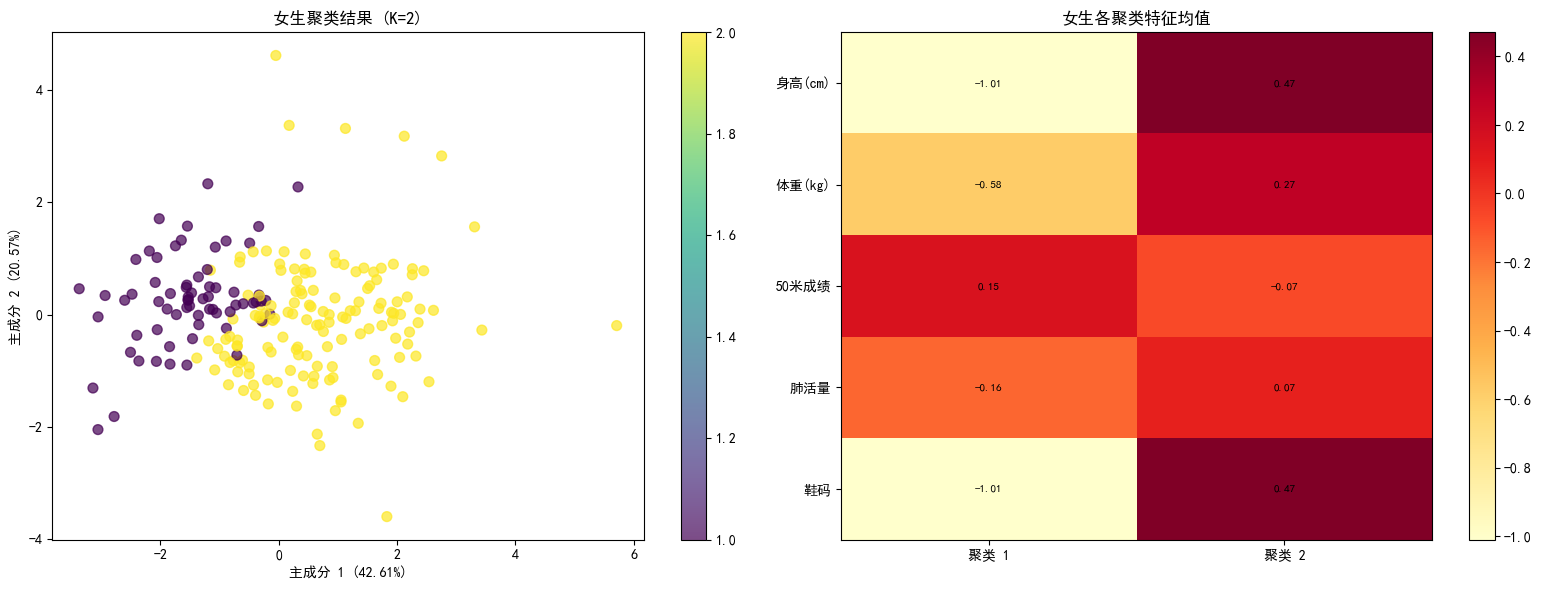


女生各聚类特征分析:

聚类 1 (样本数: 67)
  身高(cm): -1.01 ± 0.62
  体重(kg): -0.58 ± 0.48
  50米成绩: 0.15 ± 0.84
  肺活量: -0.16 ± 1.11
  鞋码: -1.01 ± 0.60

聚类 2 (样本数: 144)
  身高(cm): 0.47 ± 0.77
  体重(kg): 0.27 ± 1.07
  50米成绩: -0.07 ± 1.07
  肺活量: 0.07 ± 0.94
  鞋码: 0.47 ± 0.78


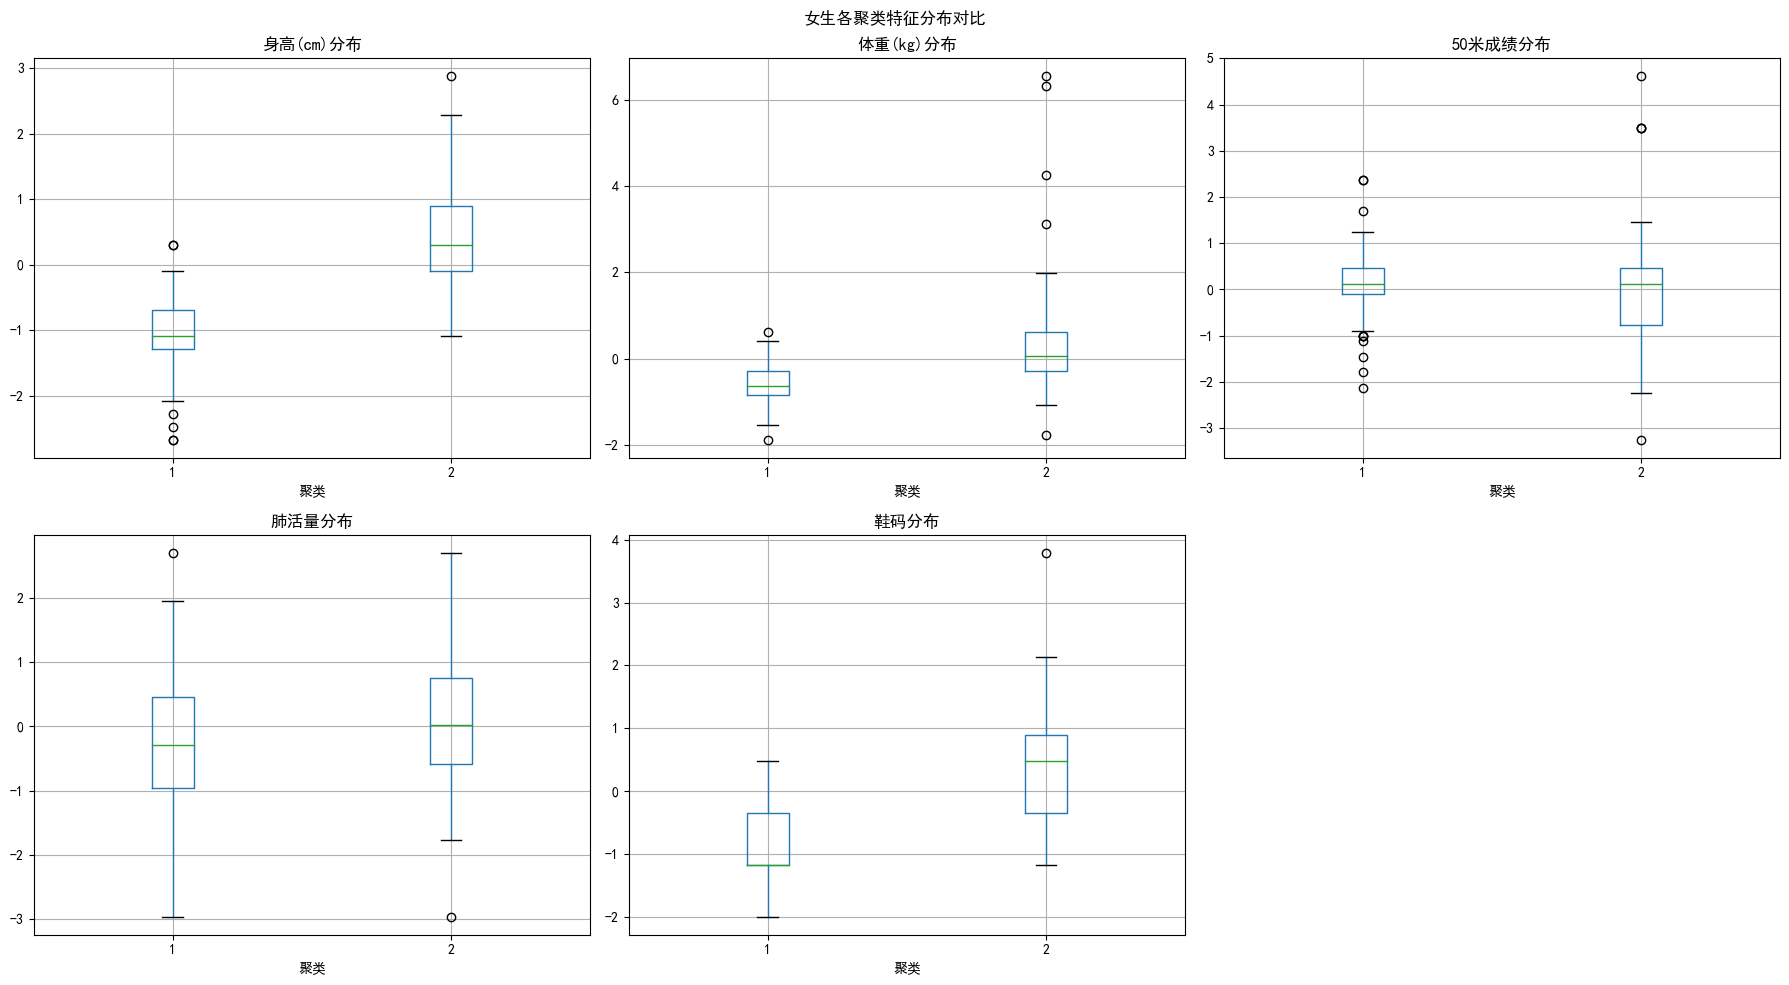


男女生聚类结果比较


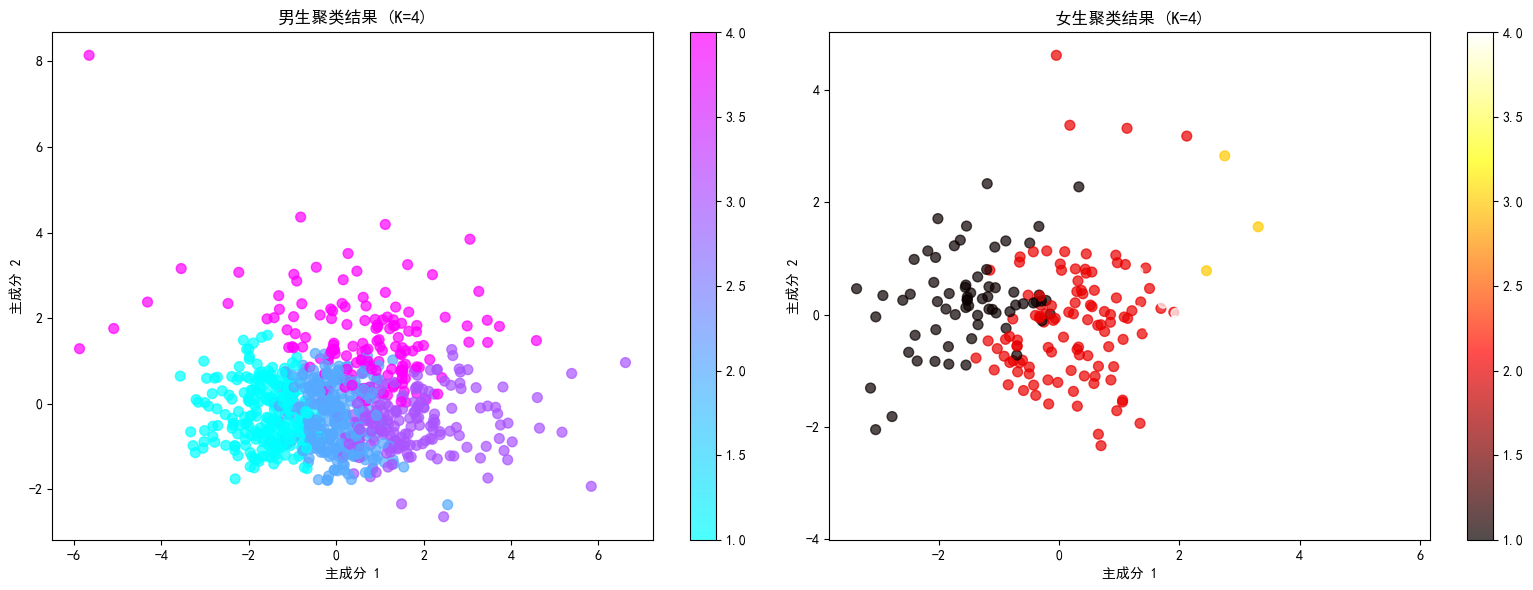

男生聚类轮廓系数: 0.1314
女生聚类轮廓系数: 0.1738

数据统计摘要

男生数据统计 (n=845):
           身高(cm)      体重(kg)       50米成绩          肺活量          鞋码
count  845.000000  845.000000  845.000000   845.000000  845.000000
mean   174.712544   68.220237    7.557598  4260.297041   42.003550
std      6.033733   10.122508    0.680543   756.705018    1.510426
min    140.000000   40.000000    5.900000   420.000000   36.000000
25%    170.000000   61.000000    7.000000  3800.000000   41.000000
50%    175.000000   66.000000    7.500000  4200.000000   42.000000
75%    179.000000   75.000000    8.000000  4800.000000   43.000000
max    198.000000  115.000000   12.300000  8300.000000   58.000000

女生数据统计 (n=211):
           身高(cm)      体重(kg)       50米成绩          肺活量          鞋码
count  211.000000  211.000000  211.000000   211.000000  211.000000
mean   163.483412   52.445498    8.895498  3191.052133   37.414692
std      5.056204    8.825996    0.892690   674.841507    1.214916
min    150.000000   36.000000    6.000000  1200.00000

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class HierarchicalClusteringAnalysis:
    def __init__(self, data_path):
        """初始化层次聚类分析类"""
        self.data = pd.read_excel(data_path)
        # 修正列名
        self.data = self.data.rename(columns={'性别 男1女0': '性别'})
        self.features = ['身高(cm)', '体重(kg)', '50米成绩', '肺活量', '鞋码']
        self.processed_data = None
        
    def preprocess_data(self):
        """数据预处理"""
        # 复制数据
        df = self.data.copy()
        
        print("原始数据列名:", df.columns.tolist())
        print("数据形状:", df.shape)
        
        # 处理异常值和不规范数据
        df['性别'] = pd.to_numeric(df['性别'], errors='coerce')
        print(f"性别列唯一值: {df['性别'].unique()}")
        
        # 只保留性别为0或1的记录
        df = df[df['性别'].isin([0, 1])]
        print(f"过滤后数据量: {len(df)}")
        
        # 处理特征数据
        for feature in self.features:
            df[feature] = pd.to_numeric(df[feature], errors='coerce')
            print(f"{feature} - 非空值数量: {df[feature].notna().sum()}")
        
        # 删除缺失值
        df_clean = df.dropna(subset=self.features)
        print(f"删除缺失值后数据量: {len(df_clean)}")
        
        # 去除极端异常值
        initial_count = len(df_clean)
        for feature in self.features:
            Q1 = df_clean[feature].quantile(0.05)
            Q3 = df_clean[feature].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            before = len(df_clean)
            df_clean = df_clean[(df_clean[feature] >= lower_bound) & 
                              (df_clean[feature] <= upper_bound)]
            after = len(df_clean)
            if before != after:
                print(f"特征 {feature}: 移除 {before - after} 个异常值")
        
        print(f"最终处理后数据量: {len(df_clean)}")
        print(f"男生数量: {len(df_clean[df_clean['性别'] == 1])}")
        print(f"女生数量: {len(df_clean[df_clean['性别'] == 0])}")
        
        self.processed_data = df_clean
        return df_clean
    
    def perform_hierarchical_clustering(self, data, gender_name, linkage_method='ward'):
        """执行层次聚类分析"""
        # 标准化数据
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        # 执行层次聚类
        Z = linkage(data_scaled, method=linkage_method, metric='euclidean')
        
        return Z, data_scaled
    
    def plot_dendrogram(self, Z, gender_name, max_d=None, figsize=(15, 8)):
        """绘制树状图"""
        plt.figure(figsize=figsize)
        
        # 创建树状图
        dendrogram(Z, 
                  truncate_mode='lastp',  # 显示最后p个聚类
                  p=50,  # 显示最后50个合并
                  show_leaf_counts=True,
                  leaf_rotation=90,
                  leaf_font_size=8,
                  show_contracted=True,
                  color_threshold=max_d if max_d else 0.7 * max(Z[:, 2]))
        
        if max_d:
            plt.axhline(y=max_d, c='red', linestyle='--', label=f'切割阈值: {max_d}')
            plt.legend()
        
        plt.title(f'{gender_name}层次聚类树状图')
        plt.xlabel('样本索引')
        plt.ylabel('距离')
        plt.tight_layout()
        plt.show()
        
        return plt.gcf()
    
    def analyze_linkage_methods(self, data, gender_name):
        """比较不同的连接方法"""
        linkage_methods = ['ward', 'complete', 'average', 'single']
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        axes = axes.flatten()
        
        results = {}
        
        for i, method in enumerate(linkage_methods):
            # 执行层次聚类
            Z = linkage(data, method=method, metric='euclidean')
            results[method] = Z
            
            # 绘制树状图
            axes[i].set_title(f'{gender_name} - {method}方法')
            dendrogram(Z, 
                      truncate_mode='lastp',
                      p=30,
                      leaf_rotation=90,
                      leaf_font_size=8,
                      show_contracted=True,
                      ax=axes[i])
        
        plt.tight_layout()
        plt.show()
        
        return results
    
    def analyze_different_clusters(self, Z, data_scaled, gender_name, max_clusters=10):
        """分析不同聚类数量的效果"""
        silhouette_scores = []
        cluster_counts = range(2, min(max_clusters + 1, len(data_scaled)))
        
        for n_clusters in cluster_counts:
            # 根据距离阈值获取聚类标签
            labels = fcluster(Z, t=n_clusters, criterion='maxclust')
            if len(np.unique(labels)) > 1:  # 确保有多个聚类
                score = silhouette_score(data_scaled, labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(-1)
        
        # 绘制轮廓系数图
        plt.figure(figsize=(10, 6))
        plt.plot(cluster_counts, silhouette_scores, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('聚类数量')
        plt.ylabel('轮廓系数')
        plt.title(f'{gender_name} - 不同聚类数量的轮廓系数')
        plt.grid(True, alpha=0.3)
        
        # 标记最佳聚类数
        best_idx = np.argmax(silhouette_scores)
        best_k = cluster_counts[best_idx]
        best_score = silhouette_scores[best_idx]
        
        plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
        plt.text(best_k, best_score, f'最佳: K={best_k}\n分数={best_score:.4f}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        return best_k, dict(zip(cluster_counts, silhouette_scores))
    
    def visualize_clusters(self, Z, data_scaled, gender_name, n_clusters=4):
        """可视化聚类结果"""
        # 获取聚类标签
        labels = fcluster(Z, t=n_clusters, criterion='maxclust')
        
        # 使用PCA降维进行可视化
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data_scaled)
        
        # 计算解释方差比例
        explained_variance = pca.explained_variance_ratio_
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 散点图
        scatter = ax1.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, 
                             cmap='viridis', alpha=0.7, s=50)
        ax1.set_xlabel(f'主成分 1 ({explained_variance[0]:.2%})')
        ax1.set_ylabel(f'主成分 2 ({explained_variance[1]:.2%})')
        ax1.set_title(f'{gender_name}聚类结果 (K={n_clusters})')
        plt.colorbar(scatter, ax=ax1)
        
        # 特征均值热图
        data_df = pd.DataFrame(data_scaled, columns=self.features)
        data_df['cluster'] = labels
        
        cluster_means = data_df.groupby('cluster').mean()
        
        im = ax2.imshow(cluster_means.T, cmap='YlOrRd', aspect='auto')
        ax2.set_xticks(range(len(cluster_means)))
        ax2.set_xticklabels([f'聚类 {i+1}' for i in range(len(cluster_means))])
        ax2.set_yticks(range(len(self.features)))
        ax2.set_yticklabels(self.features)
        ax2.set_title(f'{gender_name}各聚类特征均值')
        
        # 在热图上添加数值
        for i in range(len(cluster_means)):
            for j in range(len(self.features)):
                text = ax2.text(i, j, f'{cluster_means.iloc[i, j]:.2f}',
                               ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=ax2)
        plt.tight_layout()
        plt.show()
        
        return labels, data_pca
    
    def compare_gender_clusters(self, male_data, female_data, n_clusters=4):
        """比较男女生聚类结果"""
        # 标准化数据
        scaler = StandardScaler()
        male_scaled = scaler.fit_transform(male_data)
        female_scaled = scaler.fit_transform(female_data)
        
        # 执行层次聚类
        Z_male = linkage(male_scaled, method='ward')
        Z_female = linkage(female_scaled, method='ward')
        
        # 获取聚类标签
        male_labels = fcluster(Z_male, t=n_clusters, criterion='maxclust')
        female_labels = fcluster(Z_female, t=n_clusters, criterion='maxclust')
        
        # 使用PCA降维
        pca = PCA(n_components=2)
        male_pca = pca.fit_transform(male_scaled)
        female_pca = pca.fit_transform(female_scaled)
        
        # 绘制比较图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 男生聚类
        scatter1 = ax1.scatter(male_pca[:, 0], male_pca[:, 1], c=male_labels, 
                              cmap='cool', alpha=0.7, s=50)
        ax1.set_xlabel('主成分 1')
        ax1.set_ylabel('主成分 2')
        ax1.set_title(f'男生聚类结果 (K={n_clusters})')
        plt.colorbar(scatter1, ax=ax1)
        
        # 女生聚类
        scatter2 = ax2.scatter(female_pca[:, 0], female_pca[:, 1], c=female_labels, 
                              cmap='hot', alpha=0.7, s=50)
        ax2.set_xlabel('主成分 1')
        ax2.set_ylabel('主成分 2')
        ax2.set_title(f'女生聚类结果 (K={n_clusters})')
        plt.colorbar(scatter2, ax=ax2)
        
        plt.tight_layout()
        plt.show()
        
        # 计算轮廓系数
        male_silhouette = silhouette_score(male_scaled, male_labels)
        female_silhouette = silhouette_score(female_scaled, female_labels)
        
        print(f"男生聚类轮廓系数: {male_silhouette:.4f}")
        print(f"女生聚类轮廓系数: {female_silhouette:.4f}")
        
        return male_labels, female_labels, male_silhouette, female_silhouette
    
    def cluster_characteristics_analysis(self, data, labels, gender_name):
        """分析各聚类的特征"""
        data_df = pd.DataFrame(data, columns=self.features)
        data_df['cluster'] = labels
        
        # 计算每个聚类的统计特征
        cluster_stats = data_df.groupby('cluster').agg(['mean', 'std', 'count'])
        
        print(f"\n{gender_name}各聚类特征分析:")
        print("=" * 50)
        
        for cluster_id in sorted(data_df['cluster'].unique()):
            cluster_data = data_df[data_df['cluster'] == cluster_id]
            print(f"\n聚类 {cluster_id} (样本数: {len(cluster_data)})")
            
            for feature in self.features:
                mean_val = cluster_data[feature].mean()
                std_val = cluster_data[feature].std()
                print(f"  {feature}: {mean_val:.2f} ± {std_val:.2f}")
        
        # 绘制聚类特征对比图
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()
        
        for i, feature in enumerate(self.features):
            if i < len(axes):
                data_df.boxplot(column=feature, by='cluster', ax=axes[i])
                axes[i].set_title(f'{feature}分布')
                axes[i].set_xlabel('聚类')
        
        # 移除多余的子图
        for i in range(len(self.features), len(axes)):
            fig.delaxes(axes[i])
        
        fig.suptitle(f'{gender_name}各聚类特征分布对比')
        plt.tight_layout()
        plt.show()
        
        return cluster_stats
    
    def run_complete_analysis(self):
        """运行完整的层次聚类分析"""
        print("开始数据预处理...")
        self.preprocess_data()
        
        if self.processed_data is None or len(self.processed_data) == 0:
            print("数据预处理失败，无法继续分析")
            return
        
        # 分离男女生数据
        male_data = self.processed_data[self.processed_data['性别'] == 1][self.features]
        female_data = self.processed_data[self.processed_data['性别'] == 0][self.features]
        
        print(f"\n男生数据量: {len(male_data)}")
        print(f"女生数据量: {len(female_data)}")
        
        # 分析男生数据
        if len(male_data) > 1:
            print("\n" + "="*50)
            print("男生层次聚类分析")
            print("="*50)
            
            # 执行层次聚类
            Z_male, male_scaled = self.perform_hierarchical_clustering(male_data, "男生")
            
            # 绘制树状图
            self.plot_dendrogram(Z_male, "男生")
            
            # 比较不同连接方法
            print("\n比较不同连接方法...")
            self.analyze_linkage_methods(male_scaled, "男生")
            
            # 分析不同聚类数量
            print("\n分析不同聚类数量...")
            best_k_male, male_scores = self.analyze_different_clusters(Z_male, male_scaled, "男生")
            
            # 可视化最佳聚类结果
            print(f"\n使用最佳聚类数 K={best_k_male} 进行可视化...")
            male_labels, male_pca = self.visualize_clusters(Z_male, male_scaled, "男生", best_k_male)
            
            # 分析聚类特征
            self.cluster_characteristics_analysis(male_scaled, male_labels, "男生")
        
        # 分析女生数据
        if len(female_data) > 1:
            print("\n" + "="*50)
            print("女生层次聚类分析")
            print("="*50)
            
            # 执行层次聚类
            Z_female, female_scaled = self.perform_hierarchical_clustering(female_data, "女生")
            
            # 绘制树状图
            self.plot_dendrogram(Z_female, "女生")
            
            # 分析不同聚类数量（使用较小的最大聚类数，因为女生数据可能较少）
            max_female_clusters = min(6, len(female_data) // 2)
            if max_female_clusters >= 2:
                print("\n分析不同聚类数量...")
                best_k_female, female_scores = self.analyze_different_clusters(
                    Z_female, female_scaled, "女生", max_female_clusters)
                
                # 可视化最佳聚类结果
                print(f"\n使用最佳聚类数 K={best_k_female} 进行可视化...")
                female_labels, female_pca = self.visualize_clusters(
                    Z_female, female_scaled, "女生", best_k_female)
                
                # 分析聚类特征
                self.cluster_characteristics_analysis(female_scaled, female_labels, "女生")
        
        # 比较男女生聚类结果
        if len(male_data) > 1 and len(female_data) > 1:
            print("\n" + "="*50)
            print("男女生聚类结果比较")
            print("="*50)
            
            # 使用相同的聚类数进行比较
            common_k = min(4, len(male_data) // 2, len(female_data) // 2)
            if common_k >= 2:
                self.compare_gender_clusters(male_data, female_data, common_k)
        
        # 打印总体统计信息
        self.print_summary_statistics(male_data, female_data)
    
    def print_summary_statistics(self, male_data, female_data):
        """打印总体统计信息"""
        print("\n" + "="*50)
        print("数据统计摘要")
        print("="*50)
        
        if len(male_data) > 0:
            print(f"\n男生数据统计 (n={len(male_data)}):")
            print(male_data.describe())
        
        if len(female_data) > 0:
            print(f"\n女生数据统计 (n={len(female_data)}):")
            print(female_data.describe())
        
        print(f"\n总体样本分布:")
        print(f"男生: {len(male_data)} 人 ({len(male_data)/len(self.processed_data)*100:.1f}%)")
        print(f"女生: {len(female_data)} 人 ({len(female_data)/len(self.processed_data)*100:.1f}%)")

# 使用示例
if __name__ == "__main__":
    # 创建层次聚类分析实例
    analyzer = HierarchicalClusteringAnalysis("2025-模式识别作业数据集汇总-.xlsx")
    
    # 运行完整分析
    analyzer.run_complete_analysis()

开始数据预处理...
原始数据形状: (1075, 11)
性别列唯一值: [1.  0.  0.5 nan]
过滤后数据量: 1072
身高数据非空数量: 1071
删除缺失值后数据量: 1071
移除 1 个身高异常值
最终处理后数据量: 1070
男生数量: 855
女生数量: 215

绘制身高直方图...


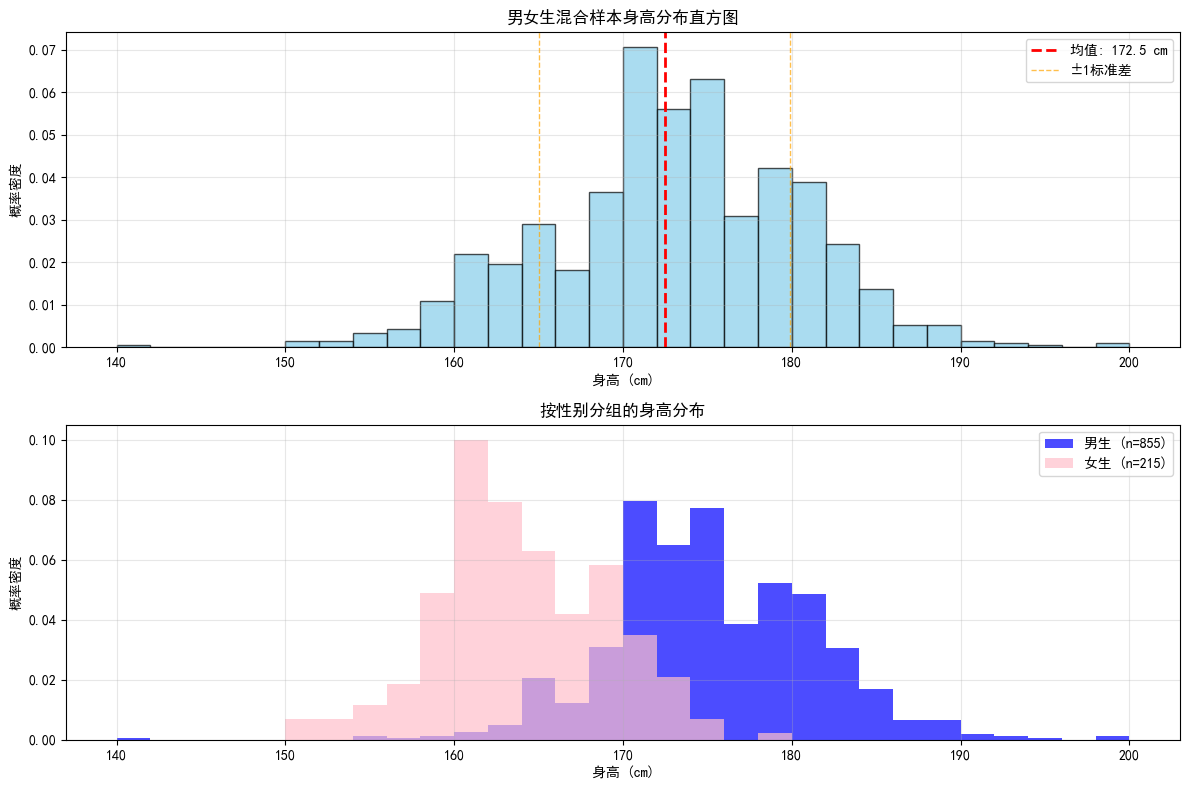


身高数据基本统计信息

总体样本:
  样本数: 1070
  均值: 172.47 cm
  标准差: 7.44 cm
  最小值: 140.0 cm
  最大值: 200.0 cm

男生样本:
  样本数: 855
  均值: 174.75 cm
  标准差: 6.08 cm

女生样本:
  样本数: 215
  均值: 163.41 cm
  标准差: 5.04 cm

男女生身高差异:
  均值差: 11.34 cm
  相对差异: 6.9%

使用EM算法拟合混合高斯分布...

使用EM算法拟合 2 个高斯分布的混合模型...

EM算法估计的混合高斯分布参数

高斯分布 1:
  权重 (混合比例): 0.6102
  均值: 171.01 cm
  标准差: 8.11 cm
  方差: 65.75

高斯分布 2:
  权重 (混合比例): 0.3898
  均值: 174.75 cm
  标准差: 5.50 cm
  方差: 30.25

推断结果:
  高斯分布 1 (均值较低): 可能对应女生身高分布
  高斯分布 2 (均值较高): 可能对应男生身高分布
  估计男生比例: 38.98%
  估计女生比例: 61.02%

绘制GMM拟合结果...


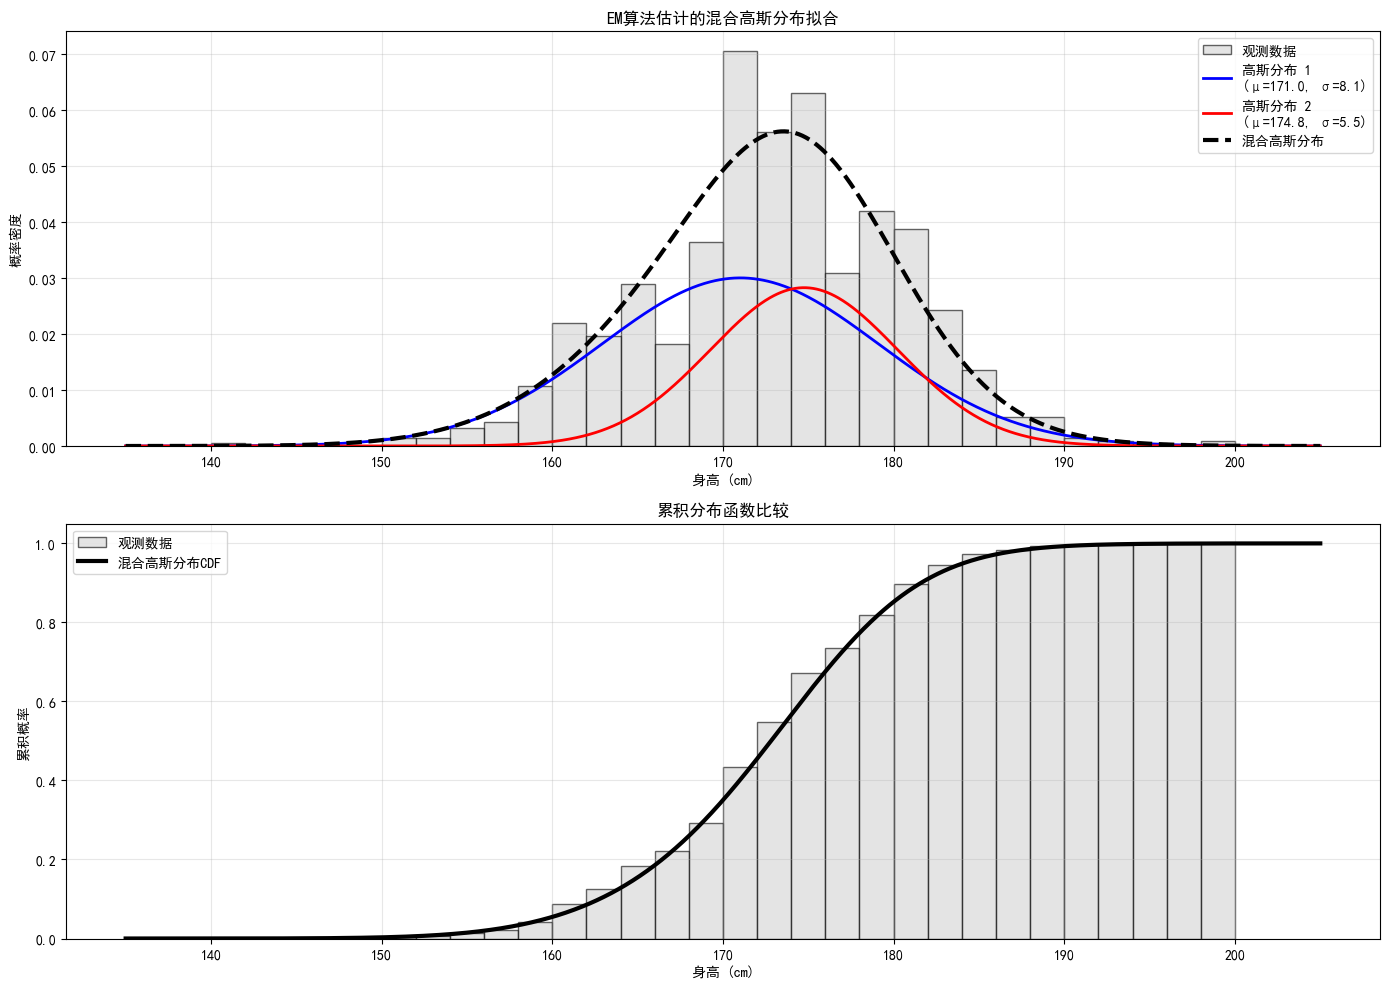


评估GMM拟合效果...

GMM模型评估
对数似然值: -3.42
AIC (赤池信息准则): 7329.23
BIC (贝叶斯信息准则): 7354.11

概率矩阵形状: (1070, 2)
前10个样本的归属概率:
  样本 1: [0.86458165 0.13541835]
  样本 2: [0.57257677 0.42742323]
  样本 3: [0.50268086 0.49731914]
  样本 4: [0.54426212 0.45573788]
  样本 5: [0.57658731 0.42341269]
  样本 6: [0.83148809 0.16851191]
  样本 7: [0.93900227 0.06099773]
  样本 8: [0.60469869 0.39530131]
  样本 9: [0.46586031 0.53413969]
  样本 10: [0.47533857 0.52466143]

比较不同组件数量的GMM...


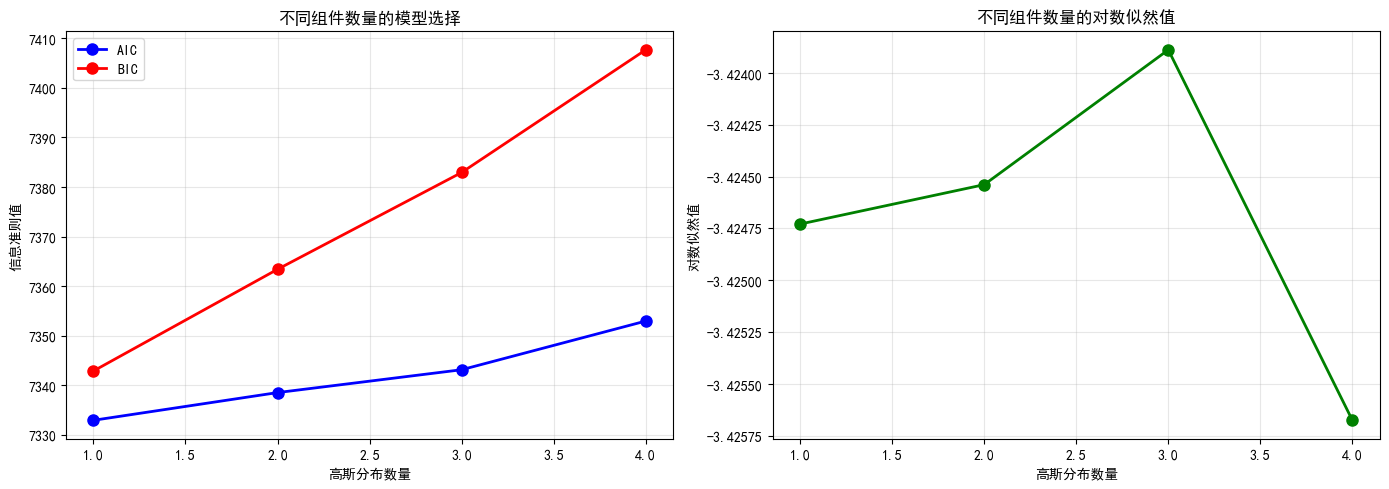


基于BIC的最优组件数: 1
基于AIC的最优组件数: 1

使用最优组件数 1 重新拟合GMM...

使用EM算法拟合 1 个高斯分布的混合模型...

EM算法估计的混合高斯分布参数

高斯分布 1:
  权重 (混合比例): 1.0000
  均值: 172.47 cm
  标准差: 7.43 cm
  方差: 55.23


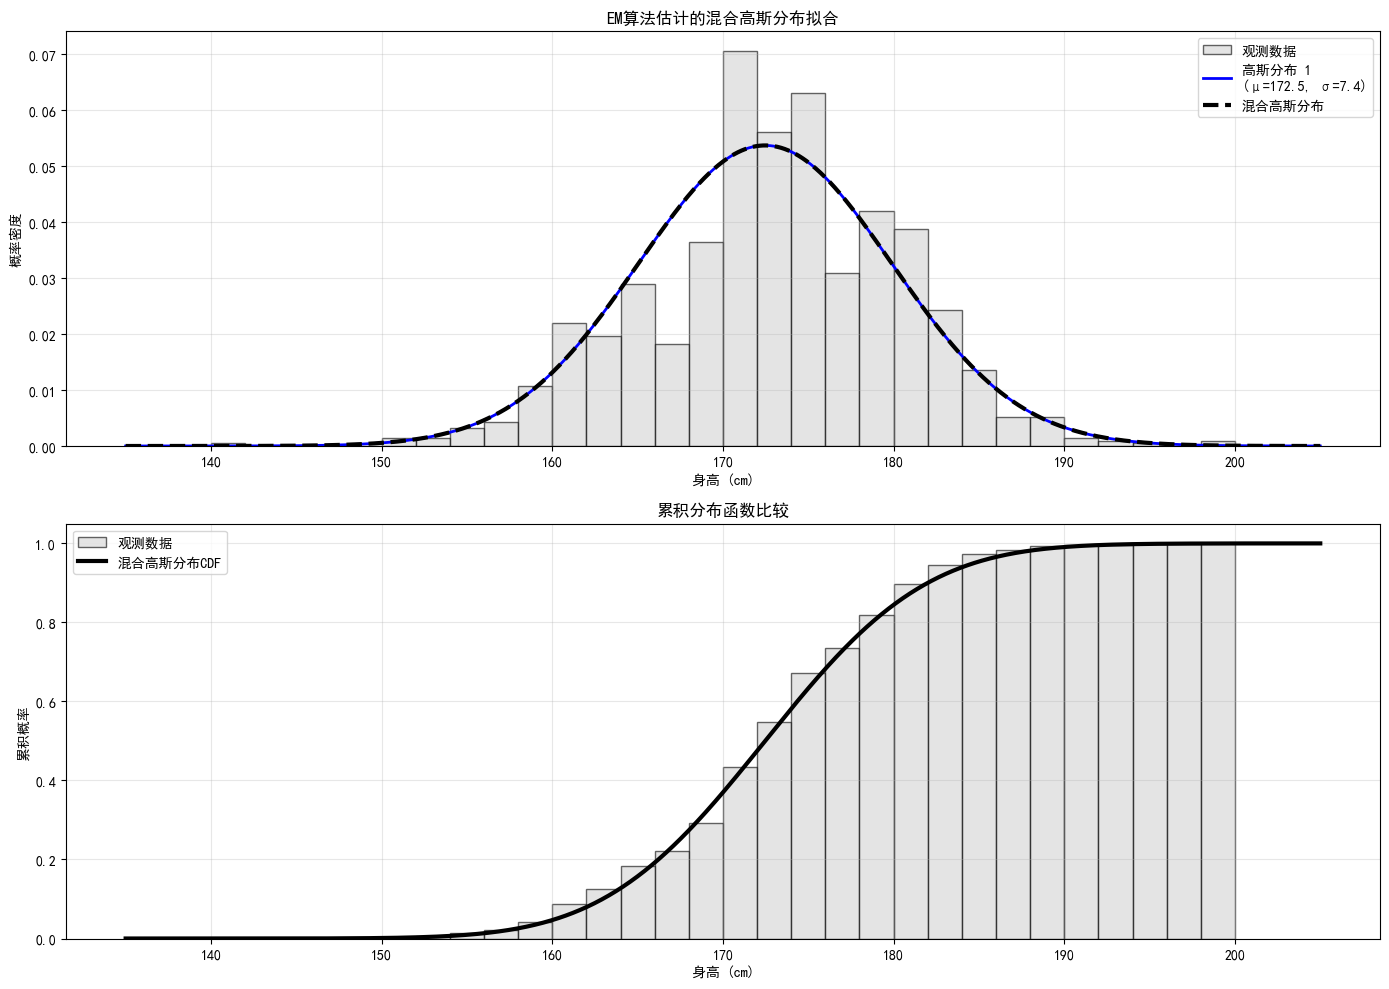

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class HeightDistributionAnalysis:
    def __init__(self, data_path):
        """初始化身高分布分析类"""
        self.data = pd.read_excel(data_path)
        # 修正列名
        self.data = self.data.rename(columns={'性别 男1女0': '性别'})
        self.height_data = None
        self.gmm = None
        self.gmm_results = None
        
    def preprocess_data(self):
        """数据预处理"""
        # 复制数据
        df = self.data.copy()
        
        print("原始数据形状:", df.shape)
        
        # 处理性别数据
        df['性别'] = pd.to_numeric(df['性别'], errors='coerce')
        print(f"性别列唯一值: {df['性别'].unique()}")
        
        # 只保留性别为0或1的记录
        df = df[df['性别'].isin([0, 1])]
        print(f"过滤后数据量: {len(df)}")
        
        # 处理身高数据
        df['身高(cm)'] = pd.to_numeric(df['身高(cm)'], errors='coerce')
        print(f"身高数据非空数量: {df['身高(cm)'].notna().sum()}")
        
        # 删除身高缺失值
        df_clean = df.dropna(subset=['身高(cm)'])
        print(f"删除缺失值后数据量: {len(df_clean)}")
        
        # 去除极端异常值
        Q1 = df_clean['身高(cm)'].quantile(0.01)
        Q3 = df_clean['身高(cm)'].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        before = len(df_clean)
        df_clean = df_clean[(df_clean['身高(cm)'] >= lower_bound) & 
                          (df_clean['身高(cm)'] <= upper_bound)]
        after = len(df_clean)
        
        if before != after:
            print(f"移除 {before - after} 个身高异常值")
        
        print(f"最终处理后数据量: {len(df_clean)}")
        print(f"男生数量: {len(df_clean[df_clean['性别'] == 1])}")
        print(f"女生数量: {len(df_clean[df_clean['性别'] == 0])}")
        
        self.height_data = df_clean[['身高(cm)', '性别']]
        return self.height_data
    
    def plot_height_histogram(self, bins=30, figsize=(12, 8)):
        """绘制身高直方图"""
        if self.height_data is None:
            self.preprocess_data()
        
        heights = self.height_data['身高(cm)']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # 总体直方图
        n, bins, patches = ax1.hist(heights, bins=bins, alpha=0.7, color='skyblue', 
                                   edgecolor='black', density=True)
        ax1.set_xlabel('身高 (cm)')
        ax1.set_ylabel('概率密度')
        ax1.set_title('男女生混合样本身高分布直方图')
        ax1.grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_height = heights.mean()
        std_height = heights.std()
        ax1.axvline(mean_height, color='red', linestyle='--', linewidth=2, 
                   label=f'均值: {mean_height:.1f} cm')
        ax1.axvline(mean_height + std_height, color='orange', linestyle='--', 
                   linewidth=1, alpha=0.7, label=f'±1标准差')
        ax1.axvline(mean_height - std_height, color='orange', linestyle='--', 
                   linewidth=1, alpha=0.7)
        ax1.legend()
        
        # 按性别分别绘制
        male_heights = self.height_data[self.height_data['性别'] == 1]['身高(cm)']
        female_heights = self.height_data[self.height_data['性别'] == 0]['身高(cm)']
        
        ax2.hist(male_heights, bins=bins, alpha=0.7, color='blue', 
                label=f'男生 (n={len(male_heights)})', density=True)
        ax2.hist(female_heights, bins=bins, alpha=0.7, color='pink', 
                label=f'女生 (n={len(female_heights)})', density=True)
        
        ax2.set_xlabel('身高 (cm)')
        ax2.set_ylabel('概率密度')
        ax2.set_title('按性别分组的身高分布')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 打印基本统计信息
        self.print_basic_statistics(heights, male_heights, female_heights)
        
        return fig
    
    def print_basic_statistics(self, all_heights, male_heights, female_heights):
        """打印基本统计信息"""
        print("\n" + "="*50)
        print("身高数据基本统计信息")
        print("="*50)
        
        print(f"\n总体样本:")
        print(f"  样本数: {len(all_heights)}")
        print(f"  均值: {all_heights.mean():.2f} cm")
        print(f"  标准差: {all_heights.std():.2f} cm")
        print(f"  最小值: {all_heights.min():.1f} cm")
        print(f"  最大值: {all_heights.max():.1f} cm")
        
        print(f"\n男生样本:")
        print(f"  样本数: {len(male_heights)}")
        print(f"  均值: {male_heights.mean():.2f} cm")
        print(f"  标准差: {male_heights.std():.2f} cm")
        
        print(f"\n女生样本:")
        print(f"  样本数: {len(female_heights)}")
        print(f"  均值: {female_heights.mean():.2f} cm")
        print(f"  标准差: {female_heights.std():.2f} cm")
        
        # 计算均值差异
        mean_diff = male_heights.mean() - female_heights.mean()
        print(f"\n男女生身高差异:")
        print(f"  均值差: {mean_diff:.2f} cm")
        print(f"  相对差异: {mean_diff/female_heights.mean()*100:.1f}%")
    
    def fit_gmm_em(self, n_components=2, random_state=42):
        """使用EM算法拟合高斯混合模型"""
        if self.height_data is None:
            self.preprocess_data()
        
        heights = self.height_data['身高(cm)'].values.reshape(-1, 1)
        
        print(f"\n使用EM算法拟合 {n_components} 个高斯分布的混合模型...")
        
        # 使用高斯混合模型（EM算法）
        self.gmm = GaussianMixture(n_components=n_components, 
                                  random_state=random_state,
                                  max_iter=1000,
                                  tol=1e-6)
        self.gmm.fit(heights)
        
        # 获取模型参数
        weights = self.gmm.weights_
        means = self.gmm.means_.flatten()
        variances = self.gmm.covariances_.flatten()
        stds = np.sqrt(variances)
        
        # 按均值排序（通常男生身高高于女生）
        sorted_indices = np.argsort(means)
        weights = weights[sorted_indices]
        means = means[sorted_indices]
        stds = stds[sorted_indices]
        
        self.gmm_results = {
            'weights': weights,
            'means': means,
            'stds': stds,
            'variances': variances[sorted_indices],
            'n_components': n_components
        }
        
        # 打印结果
        self.print_gmm_results()
        
        return self.gmm_results
    
    def print_gmm_results(self):
        """打印GMM拟合结果"""
        if self.gmm_results is None:
            print("尚未进行GMM拟合")
            return
        
        print("\n" + "="*50)
        print("EM算法估计的混合高斯分布参数")
        print("="*50)
        
        for i in range(self.gmm_results['n_components']):
            print(f"\n高斯分布 {i+1}:")
            print(f"  权重 (混合比例): {self.gmm_results['weights'][i]:.4f}")
            print(f"  均值: {self.gmm_results['means'][i]:.2f} cm")
            print(f"  标准差: {self.gmm_results['stds'][i]:.2f} cm")
            print(f"  方差: {self.gmm_results['variances'][i]:.2f}")
        
        # 根据常识判断哪个是男生分布，哪个是女生分布
        if self.gmm_results['n_components'] == 2:
            if self.gmm_results['means'][0] < self.gmm_results['means'][1]:
                print(f"\n推断结果:")
                print(f"  高斯分布 1 (均值较低): 可能对应女生身高分布")
                print(f"  高斯分布 2 (均值较高): 可能对应男生身高分布")
                print(f"  估计男生比例: {self.gmm_results['weights'][1]:.2%}")
                print(f"  估计女生比例: {self.gmm_results['weights'][0]:.2%}")
            else:
                print(f"\n推断结果:")
                print(f"  高斯分布 1 (均值较高): 可能对应男生身高分布")
                print(f"  高斯分布 2 (均值较低): 可能对应女生身高分布")
                print(f"  估计男生比例: {self.gmm_results['weights'][0]:.2%}")
                print(f"  估计女生比例: {self.gmm_results['weights'][1]:.2%}")
    
    def plot_gmm_fit(self, bins=30, figsize=(14, 10)):
        """绘制GMM拟合结果"""
        if self.gmm_results is None:
            print("请先进行GMM拟合")
            return
        
        heights = self.height_data['身高(cm)'].values
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # 绘制直方图和拟合的分布
        n, bins, patches = ax1.hist(heights, bins=bins, alpha=0.6, color='lightgray', 
                                   edgecolor='black', density=True, label='观测数据')
        
        # 生成平滑的x值
        x = np.linspace(heights.min() - 5, heights.max() + 5, 1000)
        
        # 绘制每个单独的高斯分布
        colors = ['blue', 'red', 'green', 'orange'][:self.gmm_results['n_components']]
        labels = [f'高斯分布 {i+1}' for i in range(self.gmm_results['n_components'])]
        
        for i in range(self.gmm_results['n_components']):
            y_component = (self.gmm_results['weights'][i] * 
                          norm.pdf(x, self.gmm_results['means'][i], self.gmm_results['stds'][i]))
            ax1.plot(x, y_component, color=colors[i], linewidth=2, 
                    label=f'{labels[i]}\n(μ={self.gmm_results["means"][i]:.1f}, σ={self.gmm_results["stds"][i]:.1f})')
        
        # 绘制混合分布
        y_mixture = np.zeros_like(x)
        for i in range(self.gmm_results['n_components']):
            y_mixture += (self.gmm_results['weights'][i] * 
                         norm.pdf(x, self.gmm_results['means'][i], self.gmm_results['stds'][i]))
        
        ax1.plot(x, y_mixture, color='black', linewidth=3, linestyle='--', 
                label='混合高斯分布')
        
        ax1.set_xlabel('身高 (cm)')
        ax1.set_ylabel('概率密度')
        ax1.set_title('EM算法估计的混合高斯分布拟合')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 绘制累积分布函数
        ax2.hist(heights, bins=bins, alpha=0.6, color='lightgray', 
                edgecolor='black', density=True, cumulative=True, label='观测数据')
        
        # 计算混合分布的CDF
        cdf_mixture = np.zeros_like(x)
        for i in range(self.gmm_results['n_components']):
            cdf_component = (self.gmm_results['weights'][i] * 
                           norm.cdf(x, self.gmm_results['means'][i], self.gmm_results['stds'][i]))
            cdf_mixture += cdf_component
        
        ax2.plot(x, cdf_mixture, color='black', linewidth=3, label='混合高斯分布CDF')
        
        ax2.set_xlabel('身高 (cm)')
        ax2.set_ylabel('累积概率')
        ax2.set_title('累积分布函数比较')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def evaluate_gmm_fit(self):
        """评估GMM拟合效果"""
        if self.gmm is None:
            print("请先进行GMM拟合")
            return
        
        heights = self.height_data['身高(cm)'].values.reshape(-1, 1)
        
        # 计算模型评价指标
        log_likelihood = self.gmm.score(heights)
        aic = self.gmm.aic(heights)
        bic = self.gmm.bic(heights)
        
        print("\n" + "="*50)
        print("GMM模型评估")
        print("="*50)
        print(f"对数似然值: {log_likelihood:.2f}")
        print(f"AIC (赤池信息准则): {aic:.2f}")
        print(f"BIC (贝叶斯信息准则): {bic:.2f}")
        
        # 计算每个样本属于各个分布的概率
        probabilities = self.gmm.predict_proba(heights)
        print(f"\n概率矩阵形状: {probabilities.shape}")
        print("前10个样本的归属概率:")
        for i in range(min(10, len(probabilities))):
            print(f"  样本 {i+1}: {probabilities[i]}")
    
    def compare_different_components(self, max_components=4):
        """比较不同组件数量的GMM"""
        if self.height_data is None:
            self.preprocess_data()
        
        heights = self.height_data['身高(cm)'].values.reshape(-1, 1)
        
        aic_scores = []
        bic_scores = []
        log_likelihoods = []
        
        for n in range(1, max_components + 1):
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(heights)
            
            aic_scores.append(gmm.aic(heights))
            bic_scores.append(gmm.bic(heights))
            log_likelihoods.append(gmm.score(heights))
        
        # 绘制比较图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        components_range = range(1, max_components + 1)
        
        ax1.plot(components_range, aic_scores, 'bo-', label='AIC', linewidth=2, markersize=8)
        ax1.plot(components_range, bic_scores, 'ro-', label='BIC', linewidth=2, markersize=8)
        ax1.set_xlabel('高斯分布数量')
        ax1.set_ylabel('信息准则值')
        ax1.set_title('不同组件数量的模型选择')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(components_range, log_likelihoods, 'go-', linewidth=2, markersize=8)
        ax2.set_xlabel('高斯分布数量')
        ax2.set_ylabel('对数似然值')
        ax2.set_title('不同组件数量的对数似然值')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 找到最优组件数（根据BIC，倾向于选择更简单的模型）
        best_bic = np.argmin(bic_scores) + 1
        best_aic = np.argmin(aic_scores) + 1
        
        print(f"\n基于BIC的最优组件数: {best_bic}")
        print(f"基于AIC的最优组件数: {best_aic}")
        
        return best_bic, dict(zip(components_range, zip(aic_scores, bic_scores, log_likelihoods)))
    
    def run_complete_analysis(self):
        """运行完整的身高分布分析"""
        print("开始数据预处理...")
        self.preprocess_data()
        
        print("\n绘制身高直方图...")
        self.plot_height_histogram()
        
        print("\n使用EM算法拟合混合高斯分布...")
        self.fit_gmm_em(n_components=2)
        
        print("\n绘制GMM拟合结果...")
        self.plot_gmm_fit()
        
        print("\n评估GMM拟合效果...")
        self.evaluate_gmm_fit()
        
        print("\n比较不同组件数量的GMM...")
        best_n, scores = self.compare_different_components(max_components=4)
        
        # 如果最优组件数不是2，使用最优组件数重新拟合
        if best_n != 2:
            print(f"\n使用最优组件数 {best_n} 重新拟合GMM...")
            self.fit_gmm_em(n_components=best_n)
            self.plot_gmm_fit()

# 使用示例
if __name__ == "__main__":
    # 创建身高分布分析实例
    analyzer = HeightDistributionAnalysis("2025-模式识别作业数据集汇总-.xlsx")
    
    # 运行完整分析
    analyzer.run_complete_analysis()

开始数据预处理...
原始数据列名: ['编号', '性别', '籍贯', '身高(cm)', '体重(kg)', '鞋码', '50米成绩', '肺活量', '喜欢颜色', '喜欢运动', '喜欢文学']
数据形状: (1075, 11)
性别列唯一值: [1.  0.  0.5 nan]
过滤后数据量: 1072
身高(cm) - 非空值数量: 1071
体重(kg) - 非空值数量: 1070
50米成绩 - 非空值数量: 1060
肺活量 - 非空值数量: 1063
鞋码 - 非空值数量: 1069
删除缺失值后数据量: 1058
特征 身高(cm): 移除 1 个异常值
特征 体重(kg): 移除 1 个异常值
最终处理后数据量: 1056
男生数量: 845
女生数量: 211

分析不同K值的影响...
男生数据量: 845
女生数据量: 211
正在计算 K=2...
正在计算 K=3...
正在计算 K=4...
正在计算 K=5...
正在计算 K=6...
正在计算 K=7...
正在计算 K=8...

绘制肘部法则和轮廓系数图...


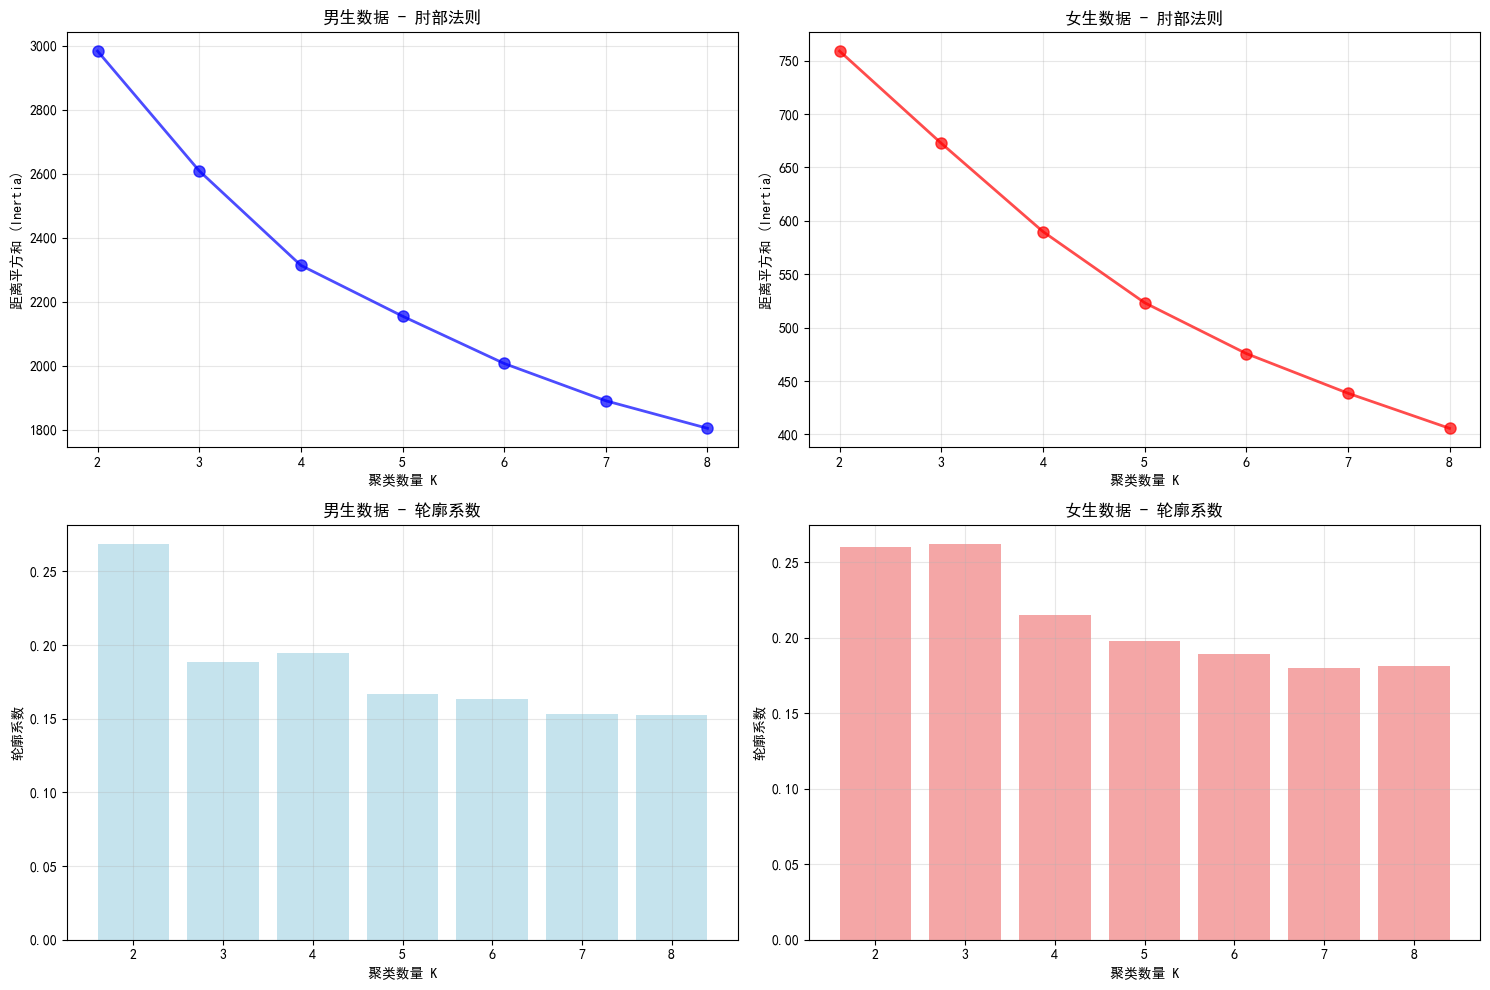


男生最优K值: 2
女生最优K值: 3

绘制聚类结果...

男生数据PCA分析结果:
主成分1解释方差比例: 0.4757
主成分2解释方差比例: 0.2139
累计解释方差比例: 0.6895

主成分特征向量（载荷）:
        身高(cm)    体重(kg)     50米成绩       肺活量        鞋码
主成分1  0.550113  0.495077 -0.022640  0.403950  0.537203
主成分2 -0.085750  0.283250  0.928935 -0.220234  0.031527

主成分1最重要的特征:
  身高(cm): 0.5501
  鞋码: 0.5372

主成分2最重要的特征:
  50米成绩: 0.9289
  体重(kg): 0.2832

女生数据PCA分析结果:
主成分1解释方差比例: 0.4261
主成分2解释方差比例: 0.2057
累计解释方差比例: 0.6318

主成分特征向量（载荷）:
        身高(cm)    体重(kg)     50米成绩       肺活量        鞋码
主成分1  0.582738  0.483241  0.029878  0.292653  0.583400
主成分2 -0.099475  0.199552  0.963969  0.045062 -0.137903

主成分1最重要的特征:
  鞋码: 0.5834
  身高(cm): 0.5827

主成分2最重要的特征:
  50米成绩: 0.9640
  体重(kg): 0.1996


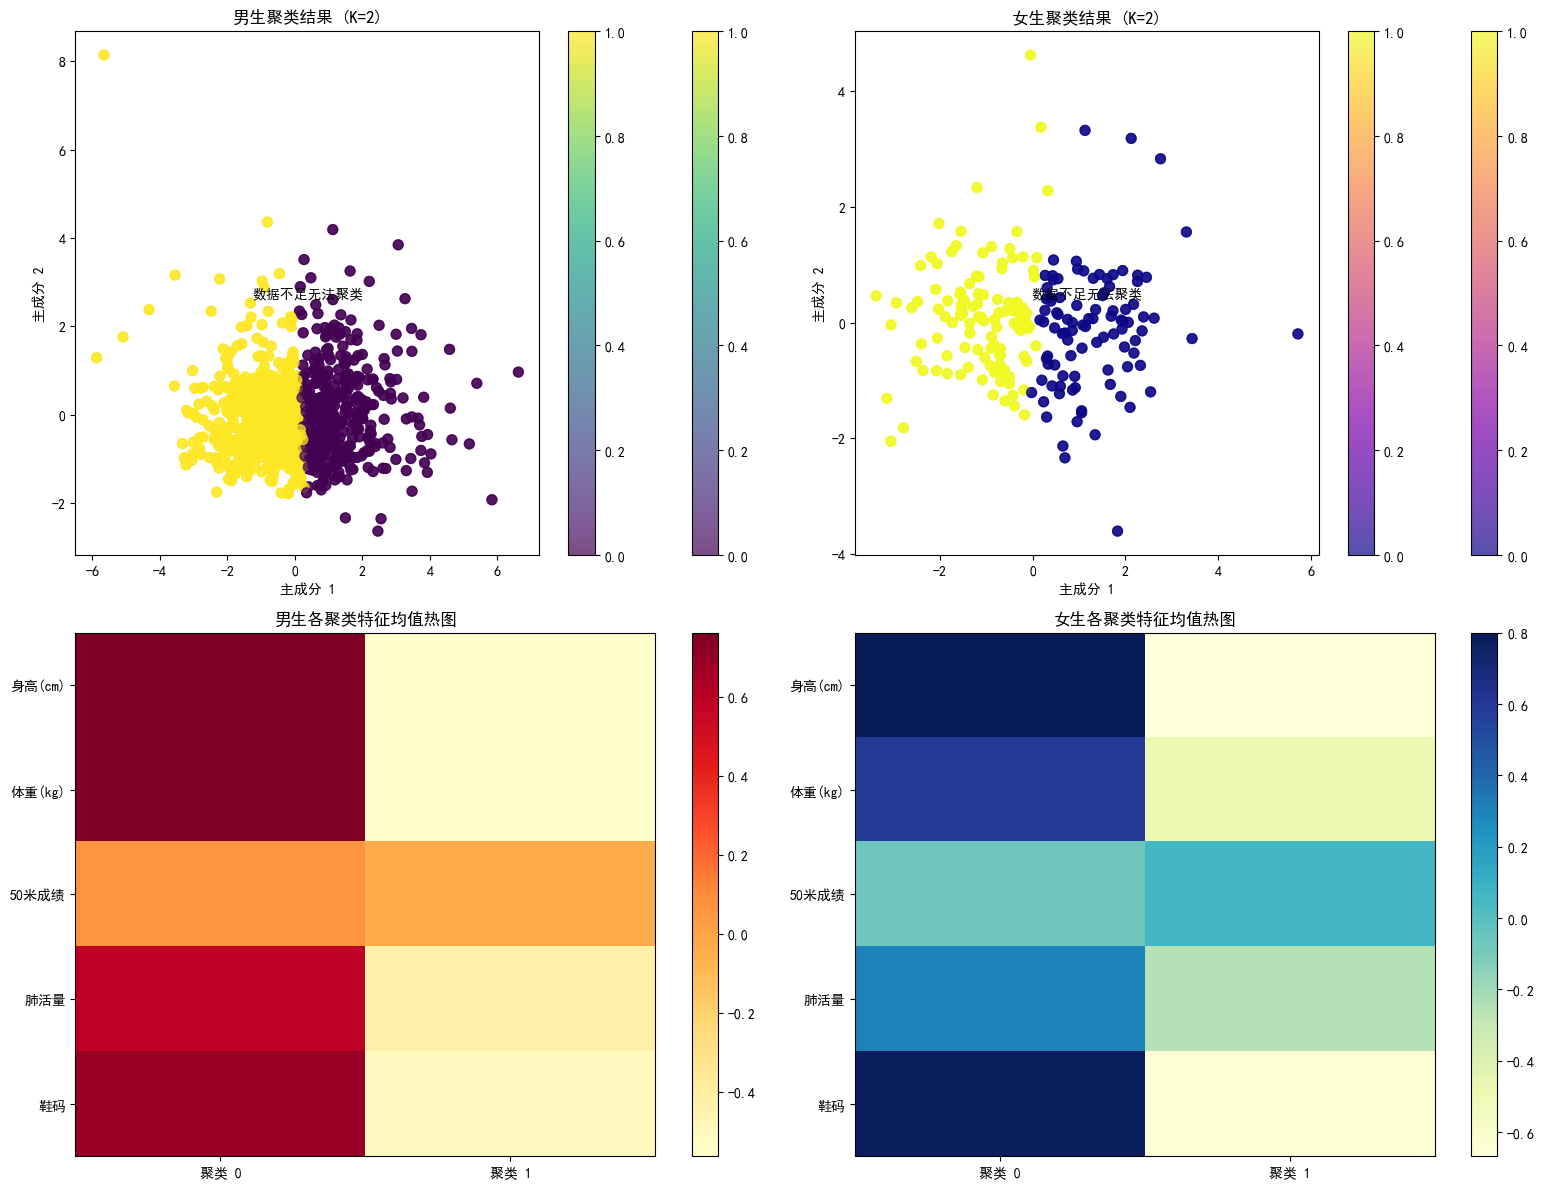


分析不同初始值的影响...

绘制初始值比较图...


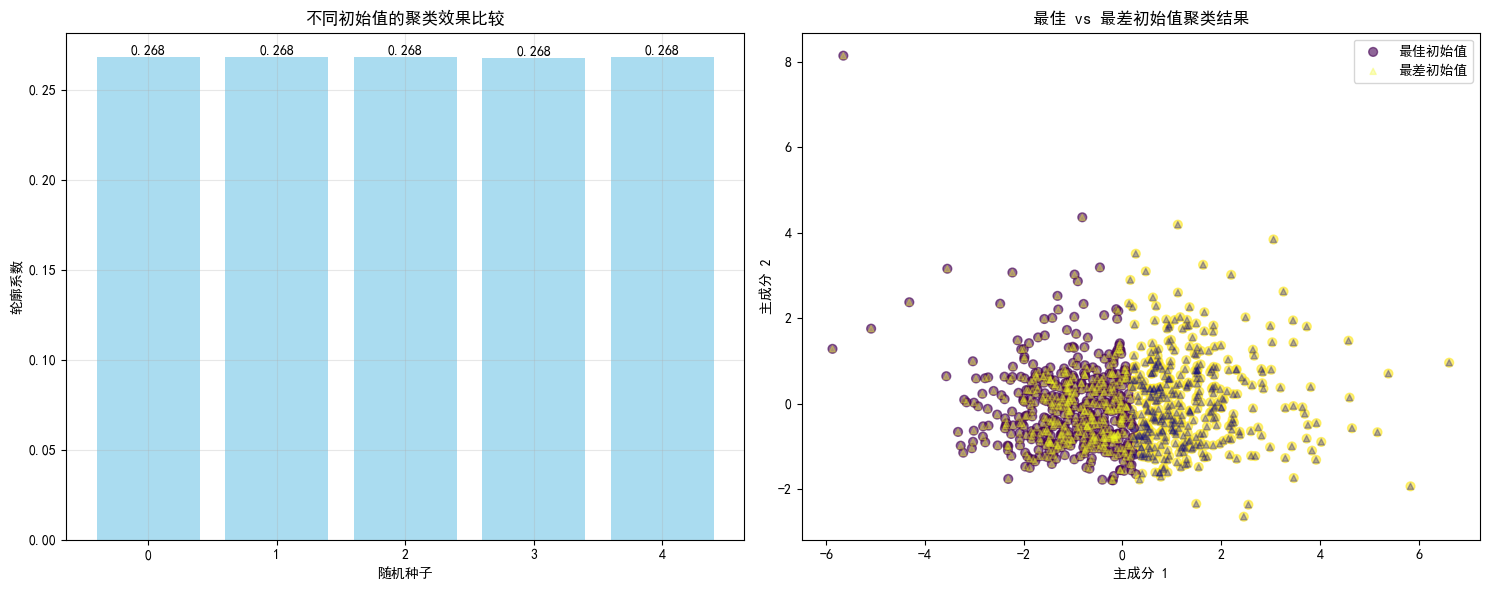

最佳初始值 (种子=0): 轮廓系数 = 0.2683
最差初始值 (种子=3): 轮廓系数 = 0.2677

聚类分析统计摘要
K=2: 男生轮廓系数=0.2683
K=3: 男生轮廓系数=0.1883
K=4: 男生轮廓系数=0.1948
K=5: 男生轮廓系数=0.1667
K=6: 男生轮廓系数=0.1635
K=7: 男生轮廓系数=0.1531
K=8: 男生轮廓系数=0.1522
K=2: 女生轮廓系数=0.2603
K=3: 女生轮廓系数=0.2617
K=4: 女生轮廓系数=0.2151
K=5: 女生轮廓系数=0.1976
K=6: 女生轮廓系数=0.1895
K=7: 女生轮廓系数=0.1800
K=8: 女生轮廓系数=0.1810

数据统计:
男生样本数: 845
女生样本数: 211

男生特征均值:
身高(cm)     174.712544
体重(kg)      68.220237
50米成绩        7.557598
肺活量       4260.297041
鞋码          42.003550
dtype: float64

女生特征均值:
身高(cm)     163.483412
体重(kg)      52.445498
50米成绩        8.895498
肺活量       3191.052133
鞋码          37.414692
dtype: float64
轮廓系数范围: 0.267743 - 0.268298
最大差异: 0.000555


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class StudentClustering:
    def __init__(self, data_path):
        """初始化聚类分析类"""
        self.data = pd.read_excel(data_path)
        # 修正列名
        self.data = self.data.rename(columns={'性别 男1女0': '性别'})
        self.features = ['身高(cm)', '体重(kg)', '50米成绩', '肺活量', '鞋码']
        self.processed_data = None
        
    def preprocess_data(self):
        """数据预处理"""
        # 复制数据
        df = self.data.copy()
        
        print("原始数据列名:", df.columns.tolist())
        print("数据形状:", df.shape)
        
        # 处理异常值和不规范数据
        df['性别'] = pd.to_numeric(df['性别'], errors='coerce')
        print(f"性别列唯一值: {df['性别'].unique()}")
        
        # 只保留性别为0或1的记录
        df = df[df['性别'].isin([0, 1])]
        print(f"过滤后数据量: {len(df)}")
        
        # 处理特征数据
        for feature in self.features:
            df[feature] = pd.to_numeric(df[feature], errors='coerce')
            print(f"{feature} - 非空值数量: {df[feature].notna().sum()}")
        
        # 删除缺失值
        df_clean = df.dropna(subset=self.features)
        print(f"删除缺失值后数据量: {len(df_clean)}")
        
        # 去除极端异常值
        initial_count = len(df_clean)
        for feature in self.features:
            Q1 = df_clean[feature].quantile(0.05)  # 使用5%和95%分位数，更宽松
            Q3 = df_clean[feature].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 使用3倍IQR，更宽松
            upper_bound = Q3 + 3 * IQR
            
            before = len(df_clean)
            df_clean = df_clean[(df_clean[feature] >= lower_bound) & 
                              (df_clean[feature] <= upper_bound)]
            after = len(df_clean)
            if before != after:
                print(f"特征 {feature}: 移除 {before - after} 个异常值")
        
        print(f"最终处理后数据量: {len(df_clean)}")
        print(f"男生数量: {len(df_clean[df_clean['性别'] == 1])}")
        print(f"女生数量: {len(df_clean[df_clean['性别'] == 0])}")
        
        self.processed_data = df_clean
        return df_clean
    
    def analyze_different_k(self, max_k=8):
        """分析不同K值对聚类效果的影响"""
        df = self.processed_data
        
        # 分离男女生数据
        male_data = df[df['性别'] == 1][self.features]
        female_data = df[df['性别'] == 0][self.features]
        
        print(f"男生数据量: {len(male_data)}")
        print(f"女生数据量: {len(female_data)}")
        
        # 标准化数据
        scaler = StandardScaler()
        male_scaled = scaler.fit_transform(male_data)
        female_scaled = scaler.fit_transform(female_data)
        
        results = {'male': {}, 'female': {}}
        
        for k in range(2, max_k + 1):
            print(f"正在计算 K={k}...")
            
            # 男生聚类
            if len(male_data) >= k:  # 确保样本数大于聚类数
                kmeans_male = KMeans(n_clusters=k, random_state=42, n_init=10)
                male_labels = kmeans_male.fit_predict(male_scaled)
                male_silhouette = silhouette_score(male_scaled, male_labels)
            else:
                male_silhouette = -1
                male_labels = None
            
            # 女生聚类
            if len(female_data) >= k:
                kmeans_female = KMeans(n_clusters=k, random_state=42, n_init=10)
                female_labels = kmeans_female.fit_predict(female_scaled)
                female_silhouette = silhouette_score(female_scaled, female_labels)
            else:
                female_silhouette = -1
                female_labels = None
            
            results['male'][k] = {
                'inertia': kmeans_male.inertia_ if len(male_data) >= k else None,
                'silhouette': male_silhouette,
                'labels': male_labels
            }
            results['female'][k] = {
                'inertia': kmeans_female.inertia_ if len(female_data) >= k else None,
                'silhouette': female_silhouette,
                'labels': female_labels
            }
        
        return results, male_scaled, female_scaled, male_data, female_data
    
    def plot_elbow_silhouette(self, results):
        """绘制肘部法则和轮廓系数图"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # 男生肘部法则
        k_values = [k for k in results['male'].keys() if results['male'][k]['inertia'] is not None]
        male_inertia = [results['male'][k]['inertia'] for k in k_values]
        ax1.plot(k_values, male_inertia, 'bo-', alpha=0.7, linewidth=2, markersize=8)
        ax1.set_xlabel('聚类数量 K')
        ax1.set_ylabel('距离平方和 (Inertia)')
        ax1.set_title('男生数据 - 肘部法则')
        ax1.grid(True, alpha=0.3)
        
        # 女生肘部法则
        k_values_f = [k for k in results['female'].keys() if results['female'][k]['inertia'] is not None]
        female_inertia = [results['female'][k]['inertia'] for k in k_values_f]
        ax2.plot(k_values_f, female_inertia, 'ro-', alpha=0.7, linewidth=2, markersize=8)
        ax2.set_xlabel('聚类数量 K')
        ax2.set_ylabel('距离平方和 (Inertia)')
        ax2.set_title('女生数据 - 肘部法则')
        ax2.grid(True, alpha=0.3)
        
        # 男生轮廓系数
        k_values_s = [k for k in results['male'].keys() if results['male'][k]['silhouette'] != -1]
        male_silhouette = [results['male'][k]['silhouette'] for k in k_values_s]
        ax3.bar(k_values_s, male_silhouette, color='lightblue', alpha=0.7)
        ax3.set_xlabel('聚类数量 K')
        ax3.set_ylabel('轮廓系数')
        ax3.set_title('男生数据 - 轮廓系数')
        ax3.grid(True, alpha=0.3)
        
        # 女生轮廓系数
        k_values_sf = [k for k in results['female'].keys() if results['female'][k]['silhouette'] != -1]
        female_silhouette = [results['female'][k]['silhouette'] for k in k_values_sf]
        ax4.bar(k_values_sf, female_silhouette, color='lightcoral', alpha=0.7)
        ax4.set_xlabel('聚类数量 K')
        ax4.set_ylabel('轮廓系数')
        ax4.set_title('女生数据 - 轮廓系数')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_cluster_results(self, results, male_scaled, female_scaled, k=4):
        """绘制聚类结果"""
        # 使用PCA降维进行可视化
        pca = PCA(n_components=2)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 男生聚类结果
        if results['male'][k]['labels'] is not None:
            male_pca = pca.fit_transform(male_scaled)
            male_labels = results['male'][k]['labels']
           
        
        
        ###
             # 新增：打印男生PCA分析结果
        print(f"\n男生数据PCA分析结果:")
        print(f"主成分1解释方差比例: {pca.explained_variance_ratio_[0]:.4f}")
        print(f"主成分2解释方差比例: {pca.explained_variance_ratio_[1]:.4f}")
        print(f"累计解释方差比例: {pca.explained_variance_ratio_.sum():.4f}")
        
        # 打印主成分的特征向量
        components_df = pd.DataFrame(
            pca.components_,
            columns=self.features,
            index=[f'主成分{i+1}' for i in range(2)]
        )
        print("\n主成分特征向量（载荷）:")
        print(components_df)
        
        # 找出每个主成分中最重要的特征
        for i in range(2):
            component_weights = pca.components_[i]
            top_features_idx = np.argsort(np.abs(component_weights))[::-1][:2]  # 取前两个最重要的特征
            print(f"\n主成分{i+1}最重要的特征:")
            for idx in top_features_idx:
                feature_name = self.features[idx]
                weight = component_weights[idx]
                print(f"  {feature_name}: {weight:.4f}")
            
            ###
            
            
            scatter1 = ax1.scatter(male_pca[:, 0], male_pca[:, 1], c=male_labels, 
                                  cmap='viridis', alpha=0.7, s=50)
            ax1.set_xlabel('主成分 1')
            ax1.set_ylabel('主成分 2')
            ax1.set_title(f'男生聚类结果 (K={k})')
            plt.colorbar(scatter1, ax=ax1)
        else:
            ax1.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title(f'男生聚类结果 (K={k})')
        
        # 女生聚类结果
        if results['female'][k]['labels'] is not None:
            female_pca = pca.fit_transform(female_scaled)
            female_labels = results['female'][k]['labels']
            
            
            ###
            # 新增：打印女生PCA分析结果
        print(f"\n女生数据PCA分析结果:")
        print(f"主成分1解释方差比例: {pca.explained_variance_ratio_[0]:.4f}")
        print(f"主成分2解释方差比例: {pca.explained_variance_ratio_[1]:.4f}")
        print(f"累计解释方差比例: {pca.explained_variance_ratio_.sum():.4f}")
        
        # 打印主成分的特征向量
        components_df = pd.DataFrame(
            pca.components_,
            columns=self.features,
            index=[f'主成分{i+1}' for i in range(2)]
        )
        print("\n主成分特征向量（载荷）:")
        print(components_df)
        
        # 找出每个主成分中最重要的特征
        for i in range(2):
            component_weights = pca.components_[i]
            top_features_idx = np.argsort(np.abs(component_weights))[::-1][:2]  # 取前两个最重要的特征
            print(f"\n主成分{i+1}最重要的特征:")
            for idx in top_features_idx:
                feature_name = self.features[idx]
                weight = component_weights[idx]
                print(f"  {feature_name}: {weight:.4f}")
            ###
            
            
            scatter2 = ax2.scatter(female_pca[:, 0], female_pca[:, 1], c=female_labels, 
                                  cmap='plasma', alpha=0.7, s=50)
            ax2.set_xlabel('主成分 1')
            ax2.set_ylabel('主成分 2')
            ax2.set_title(f'女生聚类结果 (K={k})')
            plt.colorbar(scatter2, ax=ax2)
        else:
            ax2.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title(f'女生聚类结果 (K={k})')
        
        # 男生特征分布
        if results['male'][k]['labels'] is not None:
            male_data_for_plot = pd.DataFrame(male_scaled, columns=self.features)
            male_data_for_plot['cluster'] = male_labels
            
            cluster_means_male = male_data_for_plot.groupby('cluster').mean()
            im1 = ax3.imshow(cluster_means_male.T, cmap='YlOrRd', aspect='auto')
            ax3.set_xticks(range(len(cluster_means_male)))
            ax3.set_xticklabels([f'聚类 {i}' for i in range(len(cluster_means_male))])
            ax3.set_yticks(range(len(self.features)))
            ax3.set_yticklabels(self.features)
            ax3.set_title('男生各聚类特征均值热图')
            plt.colorbar(im1, ax=ax3)
        else:
            ax3.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('男生各聚类特征均值热图')
        
        # 女生特征分布
        if results['female'][k]['labels'] is not None:
            female_data_for_plot = pd.DataFrame(female_scaled, columns=self.features)
            female_data_for_plot['cluster'] = female_labels
            
            cluster_means_female = female_data_for_plot.groupby('cluster').mean()
            im2 = ax4.imshow(cluster_means_female.T, cmap='YlGnBu', aspect='auto')
            ax4.set_xticks(range(len(cluster_means_female)))
            ax4.set_xticklabels([f'聚类 {i}' for i in range(len(cluster_means_female))])
            ax4.set_yticks(range(len(self.features)))
            ax4.set_yticklabels(self.features)
            ax4.set_title('女生各聚类特征均值热图')
            plt.colorbar(im2, ax=ax4)
        else:
            ax4.text(0.5, 0.5, '数据不足无法聚类', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('女生各聚类特征均值热图')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_different_init(self, k=4, n_inits=5):
        """分析不同初始值对聚类结果的影响"""
        df = self.processed_data
        
        male_data = df[df['性别'] == 1][self.features]
        
        if len(male_data) < k:
            print(f"男生数据量({len(male_data)})不足以进行K={k}的聚类分析")
            return [], None
        
        scaler = StandardScaler()
        male_scaled = scaler.fit_transform(male_data)
        
        init_results = []
        
        for init in range(n_inits):
            kmeans = KMeans(n_clusters=k, random_state=init, n_init=1)
            labels = kmeans.fit_predict(male_scaled)
            silhouette = silhouette_score(male_scaled, labels)
            
            init_results.append({
                'init_seed': init,
                'inertia': kmeans.inertia_,
                'silhouette': silhouette,
                'labels': labels,
                'centers': kmeans.cluster_centers_
            })
        
        return init_results, male_scaled
    
    def plot_init_comparison(self, init_results, male_scaled):
        """绘制不同初始值的比较"""
        if not init_results:
            print("没有可用的初始值比较结果")
            return
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 不同初始值的轮廓系数
        init_seeds = [r['init_seed'] for r in init_results]
        silhouettes = [r['silhouette'] for r in init_results]
        
        bars = ax1.bar(init_seeds, silhouettes, color='skyblue', alpha=0.7)
        ax1.set_xlabel('随机种子')
        ax1.set_ylabel('轮廓系数')
        ax1.set_title('不同初始值的聚类效果比较')
        ax1.grid(True, alpha=0.3)
        
        # 在柱状图上显示数值
        for bar, silhouette in zip(bars, silhouettes):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{silhouette:.3f}', ha='center', va='bottom')
        
        # 使用PCA可视化最佳和最差初始值的结果
        pca = PCA(n_components=2)
        male_pca = pca.fit_transform(male_scaled)
        
        best_idx = np.argmax(silhouettes)
        worst_idx = np.argmin(silhouettes)
        
        best_labels = init_results[best_idx]['labels']
        worst_labels = init_results[worst_idx]['labels']
        
        scatter1 = ax2.scatter(male_pca[:, 0], male_pca[:, 1], c=best_labels, 
                              cmap='viridis', alpha=0.6, s=40, label='最佳初始值')
        ax2.set_xlabel('主成分 1')
        ax2.set_ylabel('主成分 2')
        ax2.set_title('最佳 vs 最差初始值聚类结果')
        
        scatter2 = ax2.scatter(male_pca[:, 0], male_pca[:, 1], c=worst_labels, 
                              cmap='plasma', alpha=0.3, s=20, marker='^', label='最差初始值')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"最佳初始值 (种子={best_idx}): 轮廓系数 = {silhouettes[best_idx]:.4f}")
        print(f"最差初始值 (种子={worst_idx}): 轮廓系数 = {silhouettes[worst_idx]:.4f}")
    
    def run_complete_analysis(self):
        """运行完整的聚类分析"""
        print("开始数据预处理...")
        self.preprocess_data()
        
        if self.processed_data is None or len(self.processed_data) == 0:
            print("数据预处理失败，无法继续分析")
            return
        
        print("\n分析不同K值的影响...")
        results, male_scaled, female_scaled, male_data, female_data = self.analyze_different_k()
        
        print("\n绘制肘部法则和轮廓系数图...")
        self.plot_elbow_silhouette(results)
        
        # 选择最优K值（基于轮廓系数）
        valid_k_male = [k for k in results['male'].keys() if results['male'][k]['silhouette'] != -1]
        valid_k_female = [k for k in results['female'].keys() if results['female'][k]['silhouette'] != -1]
        
        if valid_k_male:
            best_k_male = max(valid_k_male, key=lambda k: results['male'][k]['silhouette'])
            print(f"\n男生最优K值: {best_k_male}")
        else:
            best_k_male = 3
            print("\n男生数据不足，使用默认K=3")
            
        if valid_k_female:
            best_k_female = max(valid_k_female, key=lambda k: results['female'][k]['silhouette'])
            print(f"女生最优K值: {best_k_female}")
        else:
            best_k_female = 3
            print("女生数据不足，使用默认K=3")
        
        print("\n绘制聚类结果...")
        # 使用较小的K值，因为女生数据可能较少
        k_to_use = min(best_k_male, best_k_female, 4)
        self.plot_cluster_results(results, male_scaled, female_scaled, k=k_to_use)
        
        print("\n分析不同初始值的影响...")
        init_results, male_scaled_init = self.analyze_different_init(k=k_to_use)
        
        if init_results:
            print("\n绘制初始值比较图...")
            self.plot_init_comparison(init_results, male_scaled_init)
        
        # 打印统计信息
        self.print_statistical_summary(results, male_data, female_data)
        
        
#         ###
#         silhouettes = [r['silhouette'] for r in init_results]
#         if len(set(silhouettes)) == 1:
#             print("所有随机种子的轮廓系数完全相同")
#         else:
#             print(f"轮廓系数范围: {min(silhouettes):.6f} - {max(silhouettes):.6f}")
#             print(f"最大差异: {max(silhouettes)-min(silhouettes):.6f}")
#         ###

    def print_statistical_summary(self, results, male_data, female_data):
        """打印统计摘要"""
        print("\n" + "="*50)
        print("聚类分析统计摘要")
        print("="*50)
        
        for k in results['male'].keys():
            if results['male'][k]['silhouette'] != -1:
                male_silhouette = results['male'][k]['silhouette']
                print(f"K={k}: 男生轮廓系数={male_silhouette:.4f}")
        
        for k in results['female'].keys():
            if results['female'][k]['silhouette'] != -1:
                female_silhouette = results['female'][k]['silhouette']
                print(f"K={k}: 女生轮廓系数={female_silhouette:.4f}")
        
        print(f"\n数据统计:")
        print(f"男生样本数: {len(male_data)}")
        print(f"女生样本数: {len(female_data)}")
        
        if len(male_data) > 0:
            print(f"\n男生特征均值:")
            print(male_data.mean())
        
        if len(female_data) > 0:
            print(f"\n女生特征均值:")
            print(female_data.mean())
         
   
        
# 使用示例
if __name__ == "__main__":
    # 创建聚类分析实例
    analyzer = StudentClustering("2025-模式识别作业数据集汇总-.xlsx")
    
    # 运行完整分析
    analyzer.run_complete_analysis()